# Fast DIRC Plotting

In [1]:
def extract_values(dicte):
    sigmas = []
    errs = []

    # dict strucutre
    # sigma_dict_fs[theta_] = [fit_params[2],fit_params[-2],auc,auc_err]
    thetas = list(dicte.keys())
    temp = list(dicte.values())

    for t in temp:
        sigmas.append(t[0])
        errs.append(t[1])

    return sigmas,errs,thetas

Momentum:  3.0
Test_FastDIRC_800k_NF_100kG
Test_FastDIRC_800k_NF_200kG
Test_FastDIRC_800k_NF_400kG
Test_FastDIRC_800k_NF_500kG
Test_FastDIRC_800k_NF_800kG
Momentum:  6.0
Test_FastDIRC_800k_NF_100kG
Test_FastDIRC_800k_NF_200kG
Test_FastDIRC_800k_NF_400kG
Test_FastDIRC_800k_NF_500kG
Test_FastDIRC_800k_NF_800kG
Momentum:  9.0
Test_FastDIRC_800k_NF_100kG
Test_FastDIRC_800k_NF_200kG
Test_FastDIRC_800k_NF_400kG
Test_FastDIRC_800k_NF_500kG
Test_FastDIRC_800k_NF_800kG


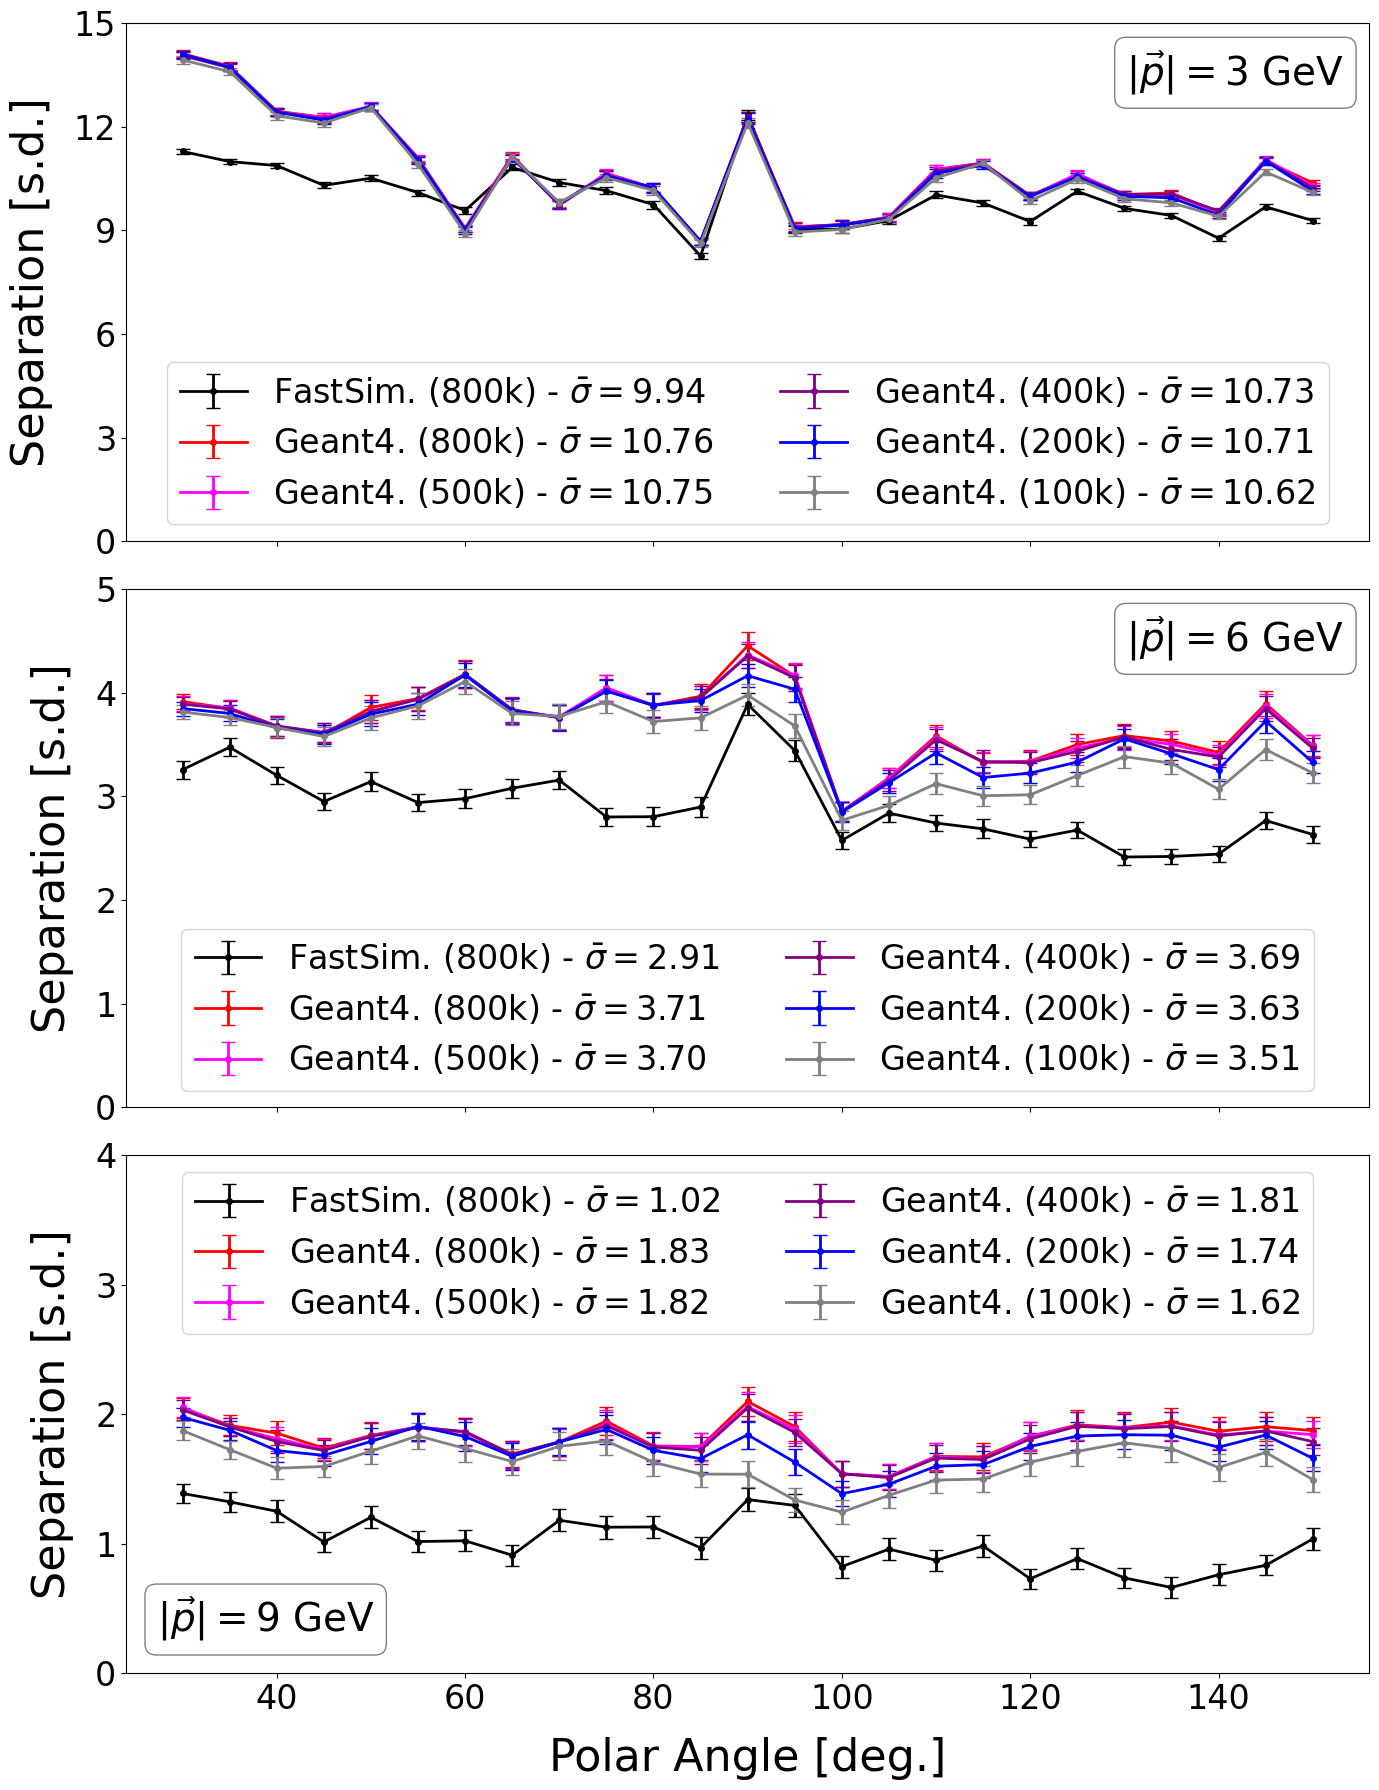

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

momentums = [3.0, 6.0, 9.0]
ylims = [(0,15),(0,5),(0,4)]
locations = ["lower center","lower center","upper center"]
locs_mom = [(0.98, 0.95),(0.98, 0.95),(0.2, 0.15)]
fig, axes = plt.subplots(3, 1, figsize=(14.2, 18),sharex=True)  # 3 rows, 1 column

for idx, mom in enumerate(momentums):
    fast_sim = {}
    geant = {}
    
    base_dir = f"KDE_Fits/{mom}"
    folders = os.listdir(base_dir)
    print("Momentum: ",mom)
    for folder in folders:
        if "PDF" in folder or "FSInference" in folder or "10k" in folder:
            continue

        print(folder)
        key_ = folder.split("_")[-1]
        fs = np.load(os.path.join(base_dir, folder, "FastSim_Sigmas.pkl"), allow_pickle=True)
        gt = np.load(os.path.join(base_dir, folder, "Geant_Sigmas.pkl"), allow_pickle=True)
        fast_sim[key_] = fs
        geant[key_] = gt

    # Plotting in corresponding subplot
    ax = axes[idx]
    
    fs_sigmas, fs_errs, fs_thetas = extract_values(fast_sim['800kG'])

    ax.errorbar(fs_thetas, fs_sigmas, yerr=fs_errs, color='k', lw=2, 
                label=r'FastSim. ({0}) - '.format("800k") + r'$\bar{\sigma} = $' + "{0:.2f}".format(np.average(fs_sigmas)), 
                capsize=5, linestyle='-', fmt='o', markersize=4)

    key_list = np.array(list(geant.keys()))[np.argsort(list(geant.keys()))]
    colors = ['red', 'magenta', 'purple', 'blue', 'gray', 'lime']
    
    for i, key in enumerate(reversed(key_list)):
        s = key.split("G")[0]
        g_sigmas, g_errs, g_thetas = extract_values(geant[key])

        ax.errorbar(g_thetas, g_sigmas, yerr=g_errs, color=colors[i], lw=2, 
                    label=r'Geant4. ({0}) - '.format(s) + r'$\bar{\sigma} = $' + "{0:.2f}".format(np.average(g_sigmas)), 
                    capsize=5, linestyle='-', fmt='o', markersize=4)

    ax.legend(fontsize=24, ncol=2,loc=locations[idx])
    if idx == 2:
        ax.set_xlabel("Polar Angle [deg.]", fontsize=32, labelpad=15)
    ax.set_ylabel("Separation [s.d.]", fontsize=32, labelpad=15)
    ax.set_ylim(ylims[idx][0],ylims[idx][1])
    ax.tick_params(axis='both', which='major', labelsize=24)
    
    if idx == 2:
        ax.set_yticks([0,1,2,3,4])
    if idx == 0:
        ax.set_yticks([0,3,6,9,12,15])

    #ax.set_title(r"$|\vec{p}| = "+ r" {0} \; GeV$".format(int(mom)), fontsize=32,pad=15)
    ax.text(locs_mom[idx][0],locs_mom[idx][1], rf"$|\vec{{p}}| = {int(mom)}$ GeV",
                transform=ax.transAxes, fontsize=28, ha='right', va='top',
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.savefig("KDE_Fits/FastSim_Geant4_FastDIRC_Comp_All.pdf",bbox_inches="tight")
plt.show()


# Look at some PDFs

In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LogNorm
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
import argparse
import json
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
####################################### hpDIRC Discretization #################################
from utils.hpDIRC import bins_x,bins_y,gapx,gapy,pixel_width,pixel_height
t_bins = np.arange(0.0,157.0,0.5)
####################################### hpDIRC Discretization #################################


def make_plots_fastsim(true_data, fastsim_data, label, momentum=6.0, theta=30, log_norm=True):
    xs = fastsim_data[:, 0]
    ys = fastsim_data[:, 1]
    time = fastsim_data[:, 2] 
    true_xs = true_data[:, 0] 
    true_ys = true_data[:, 1] 
    true_time = true_data[:, 2]

    
    
    if log_norm:
        norm = LogNorm()
    else:
        norm = None

    gs = gridspec.GridSpec(3, 2, height_ratios=[1.5, 0.5, 1])

    fig = plt.figure(figsize=(18, 12))
    ax1 = fig.add_subplot(gs[0, 0])  # Top-left
    ax2 = fig.add_subplot(gs[0, 1])  # Top-right
    ax3 = fig.add_subplot(gs[2, :])  # Bottom image, spans both columns

    ax3.set_position([
        ax1.get_position().x0 - 0.05 + (ax2.get_position().x0 - ax1.get_position().x0) / 2,  # Center horizontally
        ax3.get_position().y0 - 0.02,  # Keep original y position
        ax1.get_position().width * 1.2,  # Keep same width as top images
        ax1.get_position().height  # Keep same height
    ])

    # FastSim 2D Hit Pattern
    h_fs, xedges, yedges, im1 = ax1.hist2d(xs, ys, bins=[bins_x, bins_y], norm=norm, density=True)
    ax1.set_title(label + r" Fast Simulated Hit Pattern", fontsize=30)
    ax1.tick_params(axis="both", labelsize=28)
    ax1.set_xlabel("X (mm)",fontsize=30,labelpad=15)
    ax1.set_ylabel("Y (mm)",fontsize=30,labelpad=15)
    # Geant4 2D Hit Pattern
    h_g, xedges, yedges, im2 = ax2.hist2d(true_xs, true_ys, bins=[bins_x, bins_y], norm=norm, density=True)
    ax2.set_title(label + r" Geant4 Hit Pattern", fontsize=30)
    ax2.tick_params(axis="both", labelsize=28)
    ax2.set_xlabel("X (mm)",fontsize=30,labelpad=15)
    #ax2.set_tlabel("Y [mm]",fontsize=24)    

    # Bottom row: Combined Time Distribution
    ax3.hist(true_time, bins=t_bins, density=True, histtype='step', color='k', label="Geant4",linewidth=2)
    ax3.hist(time, bins=t_bins, density=True, histtype='step', color='r', label="FastSim.",linewidth=2)
    
    ax3.set_xlabel("Time (ns)", fontsize=30)
    ax3.tick_params(axis="both", labelsize=28)
    ax3.set_ylabel("A.U.", fontsize=30)
    ax3.set_yscale('log')
    ax3.set_ylim(1e-5, 10e-1)
    ax3.text(108, 0.5, r"$|\vec{p}|$" + f" = {int(momentum)} GeV/c" "\n" r"$\theta =$"+ f"{int(theta)}" +r"$^\circ$".format(momentum, theta), fontsize=24,
    verticalalignment='top',  # Align text at the top
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3'))
    legend_lines = [
        Line2D([0], [0], color='k', linewidth=2, label="Geant4"),
        Line2D([0], [0], color='r', linewidth=2, label="FastSim.")
    ]
    
    ax3.legend(handles=legend_lines, fontsize=24,loc='lower right')
    plt.savefig(f"KDE_Fits/Example_PDFs_theta_{theta}_p_{momentum}_PID_{label}.pdf",bbox_inches="tight")
    plt.show(block=True)

    return h_fs,h_g

Making plots for theta =  40.0


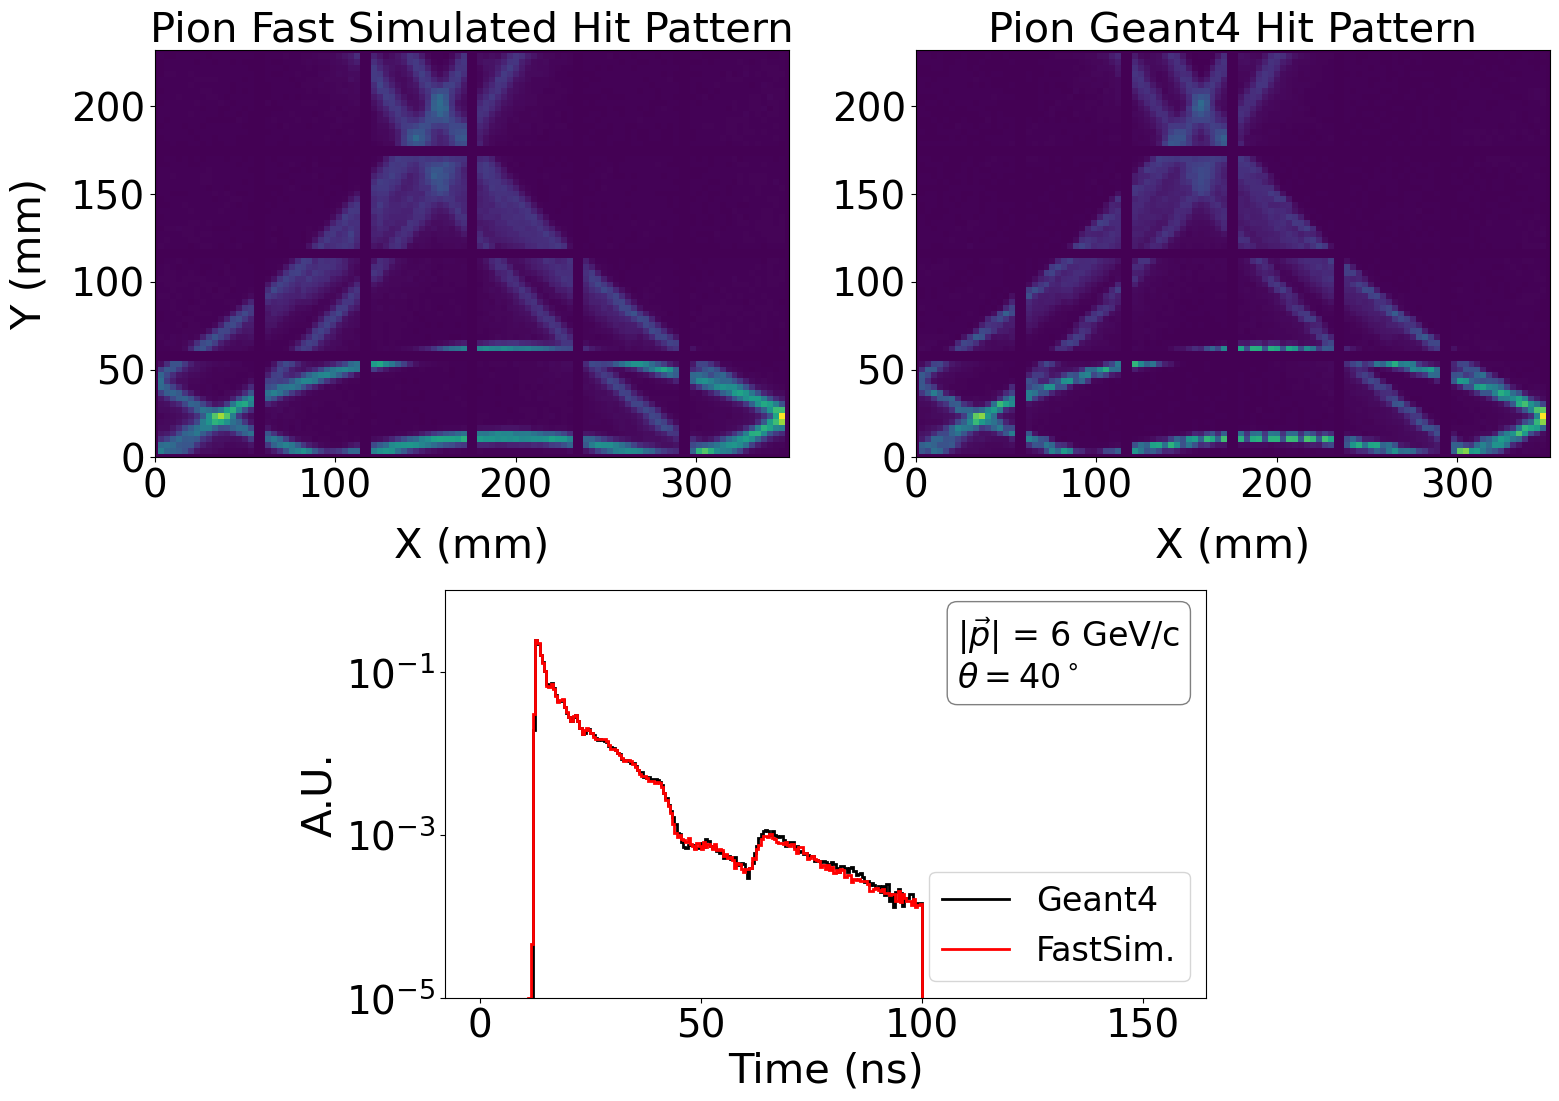

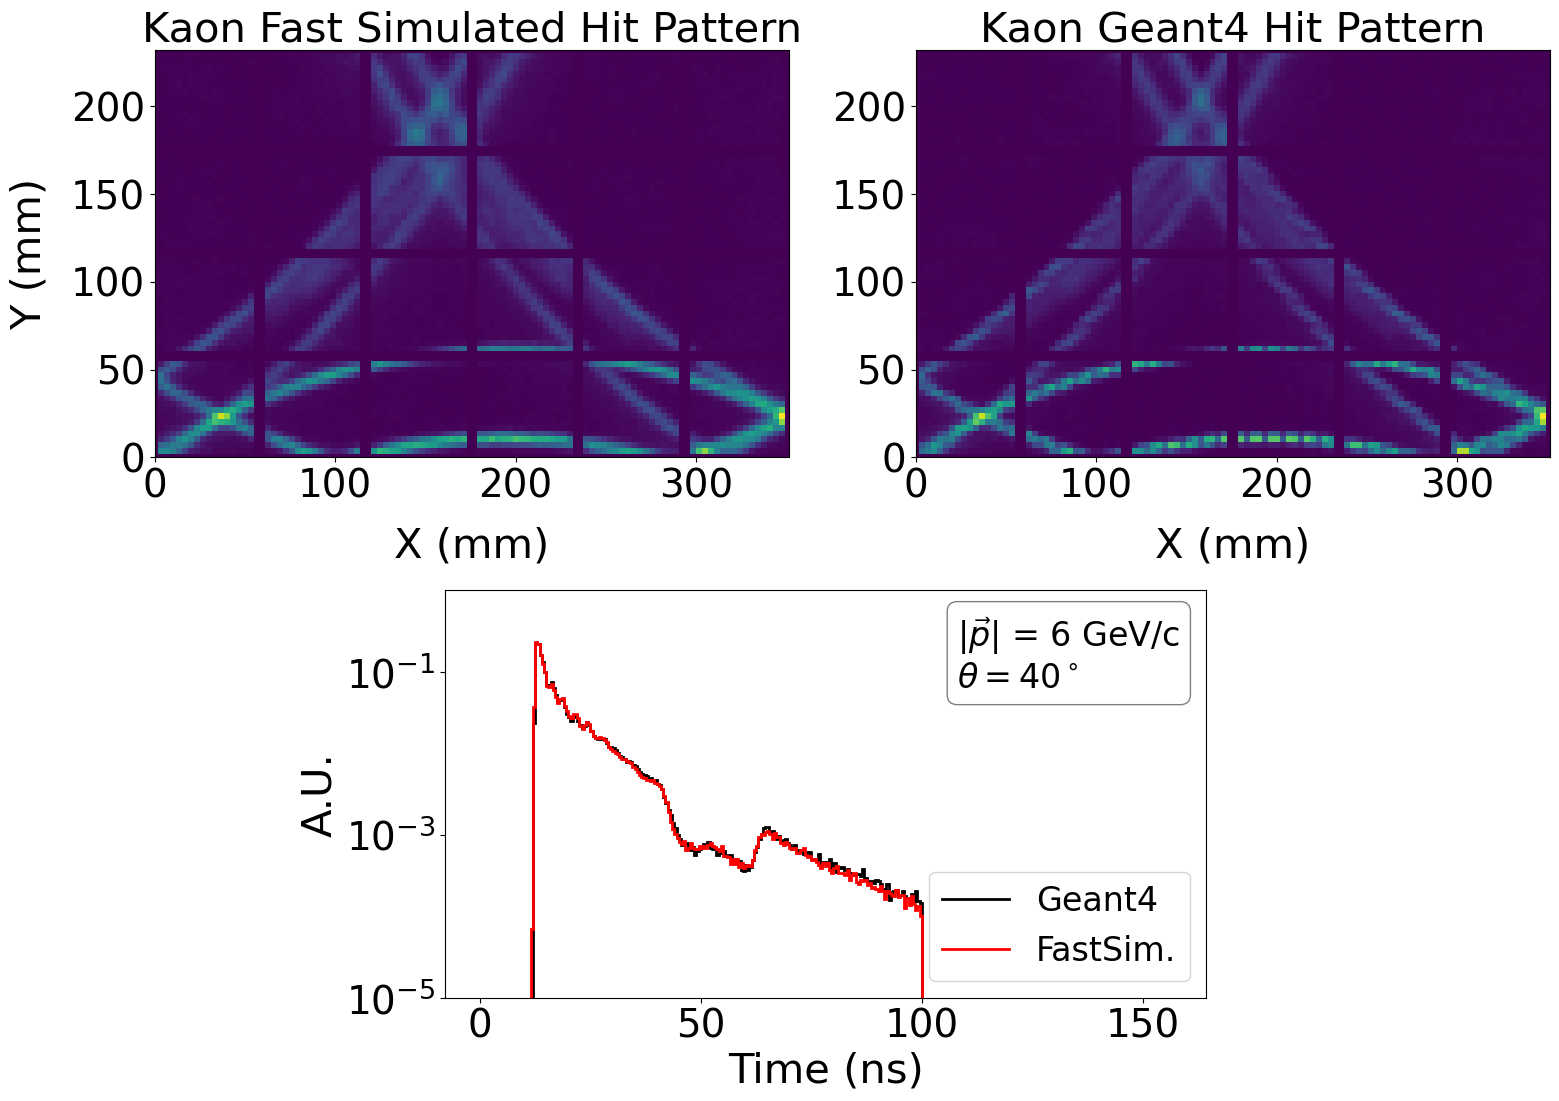

 
Making plots for theta =  100.0


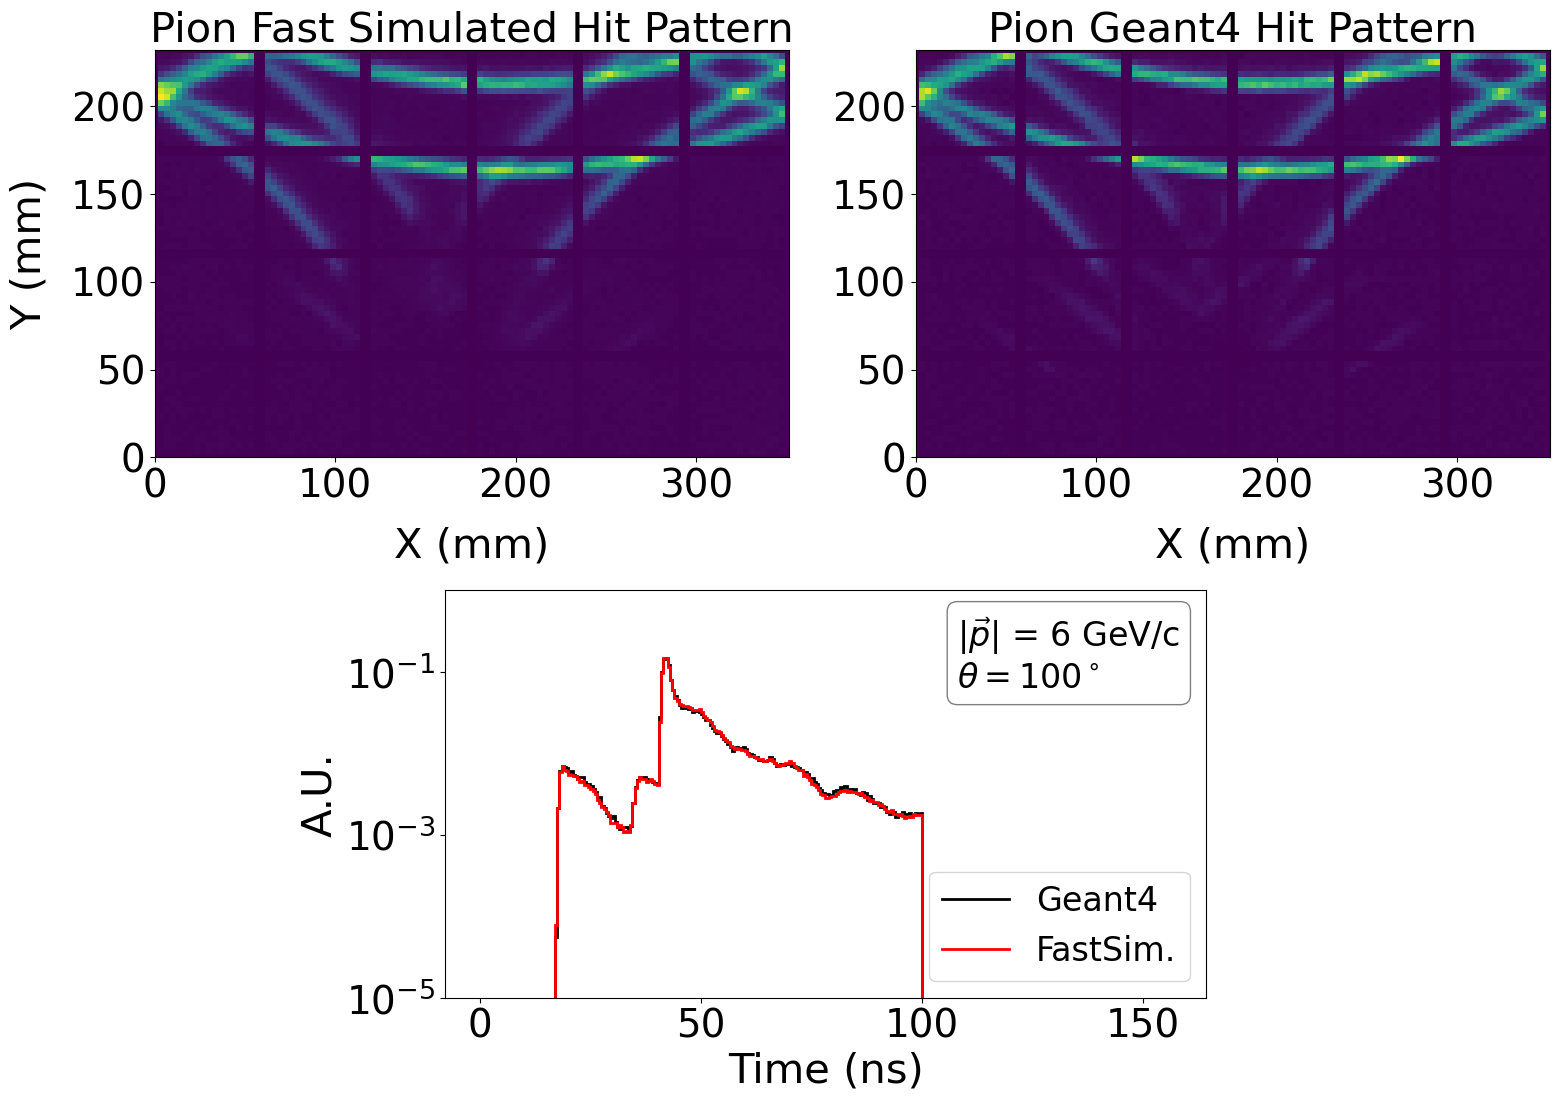

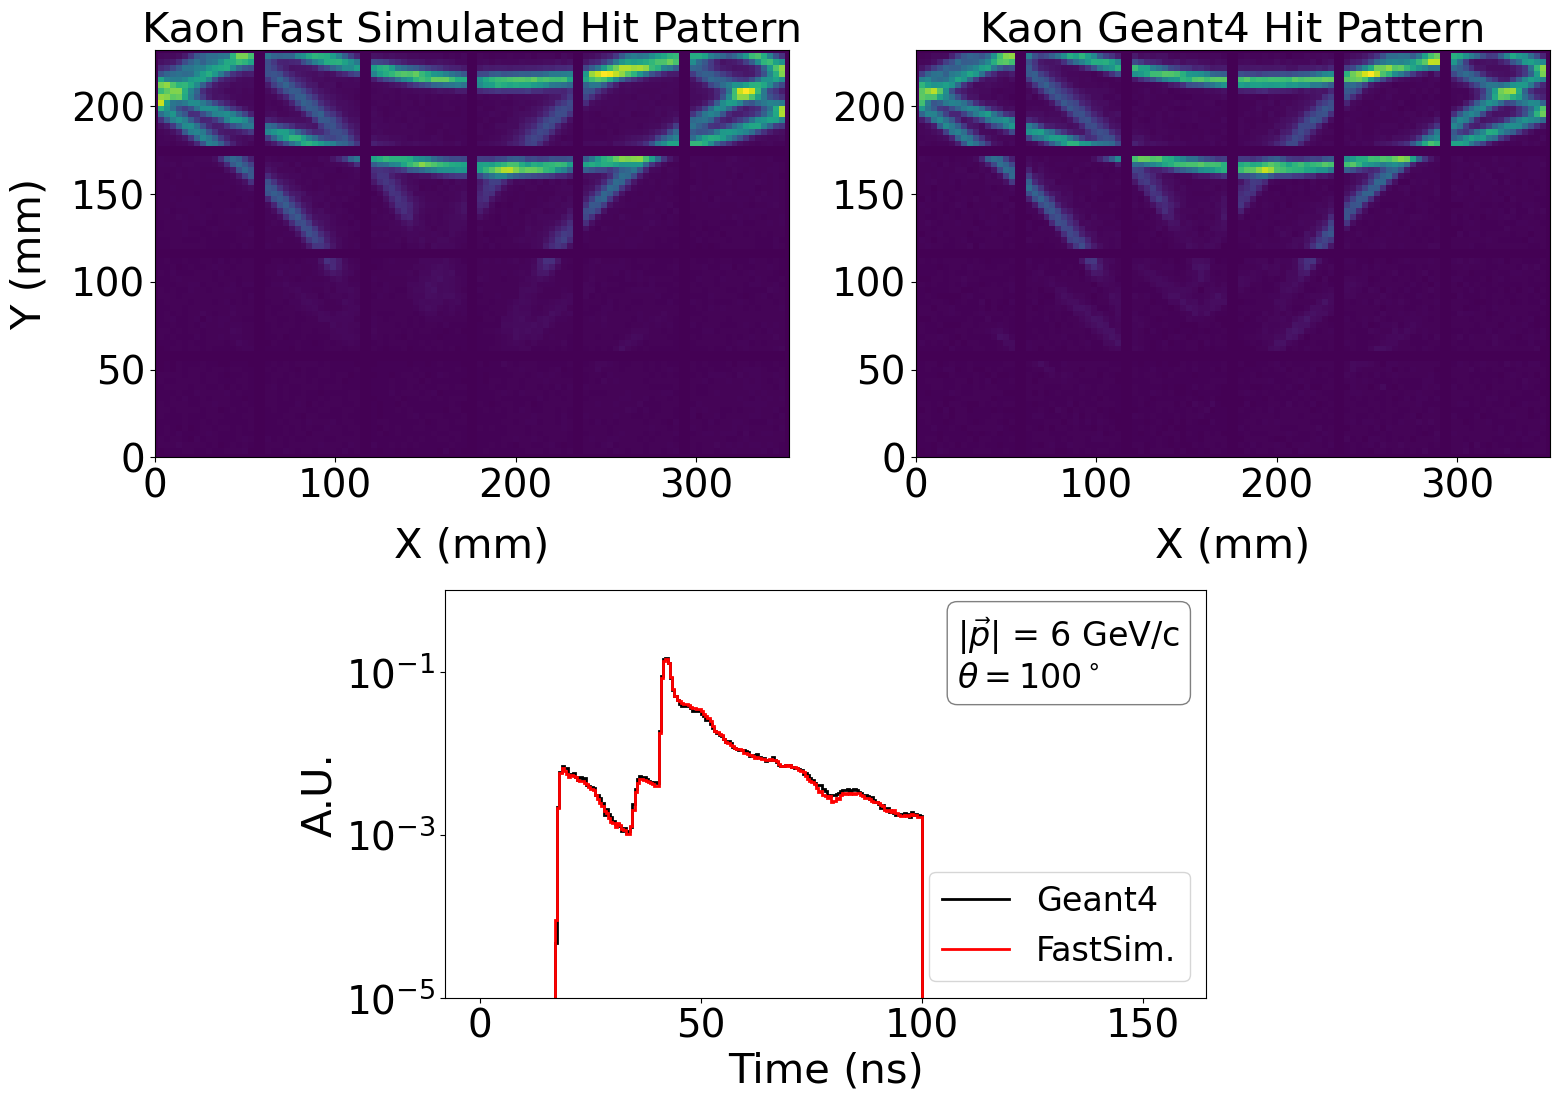

 
Making plots for theta =  130.0


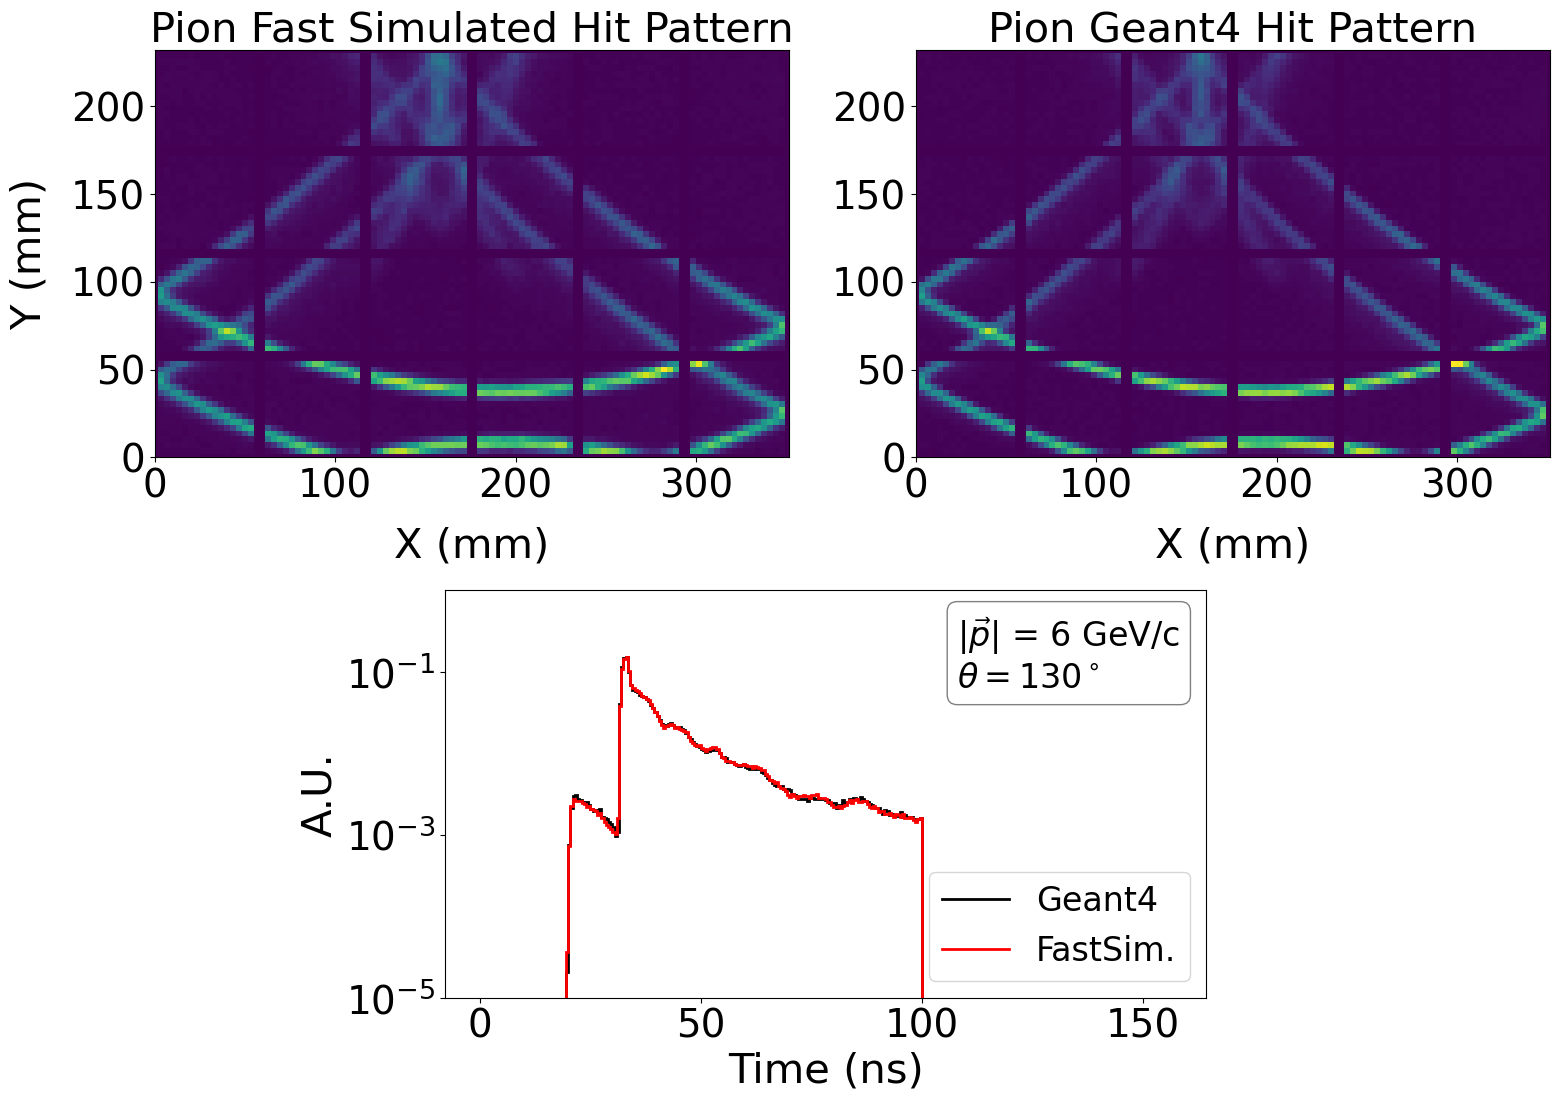

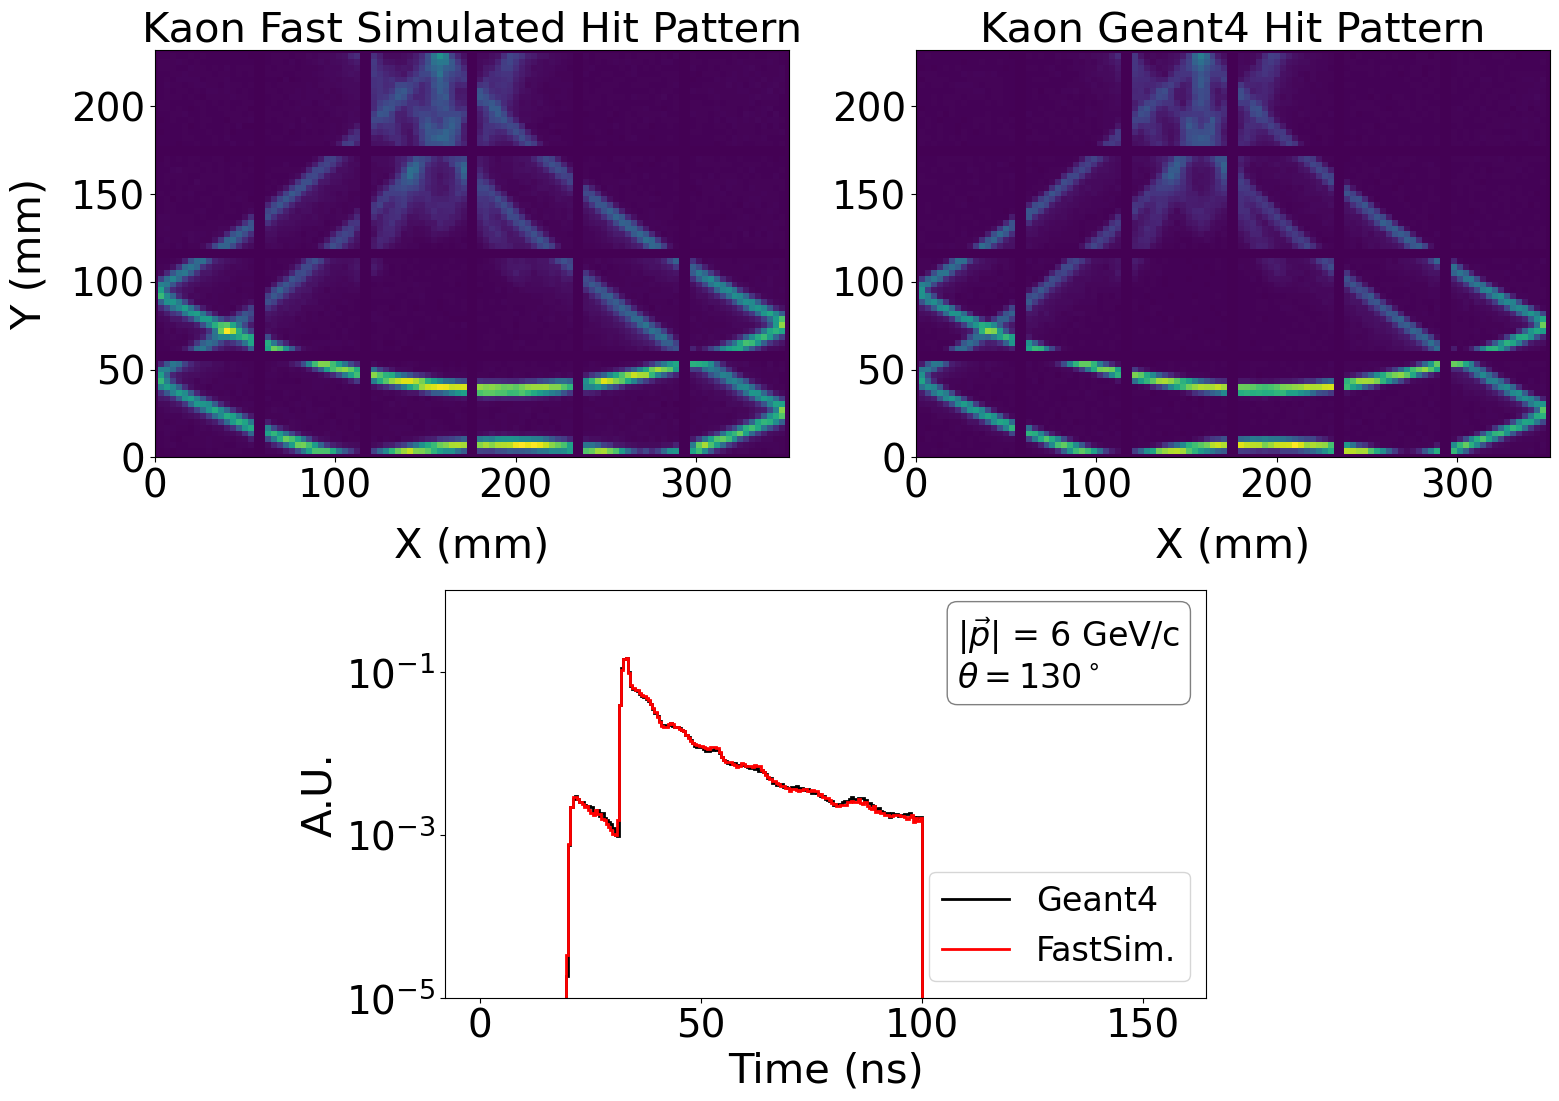

In [5]:
#thetas =  [30.,35.,40.,45.,50.,55.,60.,65.,70.,75.,80.,85.,90.,95.,100.,105.,110.,115.,120.,125.,130.,135.,140.,145.,150.] 
momentum = 6.0
log_norm=False
base_dir = f"KDE_Fits/{momentum}/Test_FastDIRC_800k_NF_800kG"
thetas = [40.,100.,130.]
for theta_ in thetas:
    print("Making plots for theta = ",theta_)
    try:
        geant_pions = np.load(os.path.join(base_dir,f"Geant_SupportPions_{theta_}.npy"))
        geant_kaons = np.load(os.path.join(base_dir,f"Geant_SupportKaons_{theta_}.npy"))
        fs_pions = np.load(os.path.join(base_dir,f"FastSim_SupportPions_{theta_}.npy"))
        fs_kaons = np.load(os.path.join(base_dir,f"FastSim_SupportKaons_{theta_}.npy"))
        h_fs_pion,h_g_pion = make_plots_fastsim(geant_pions,fs_pions,label='Pion',momentum=momentum,theta=theta_,log_norm=log_norm)
        h_fs_kaon,h_g_kaon = make_plots_fastsim(geant_kaons,fs_kaons,label='Kaon',momentum=momentum,theta=theta_,log_norm=log_norm)
    except Exception as e:  
        print("Something went wrong:", e)

        continue
    print(" ")

Making plots for theta =  40.0


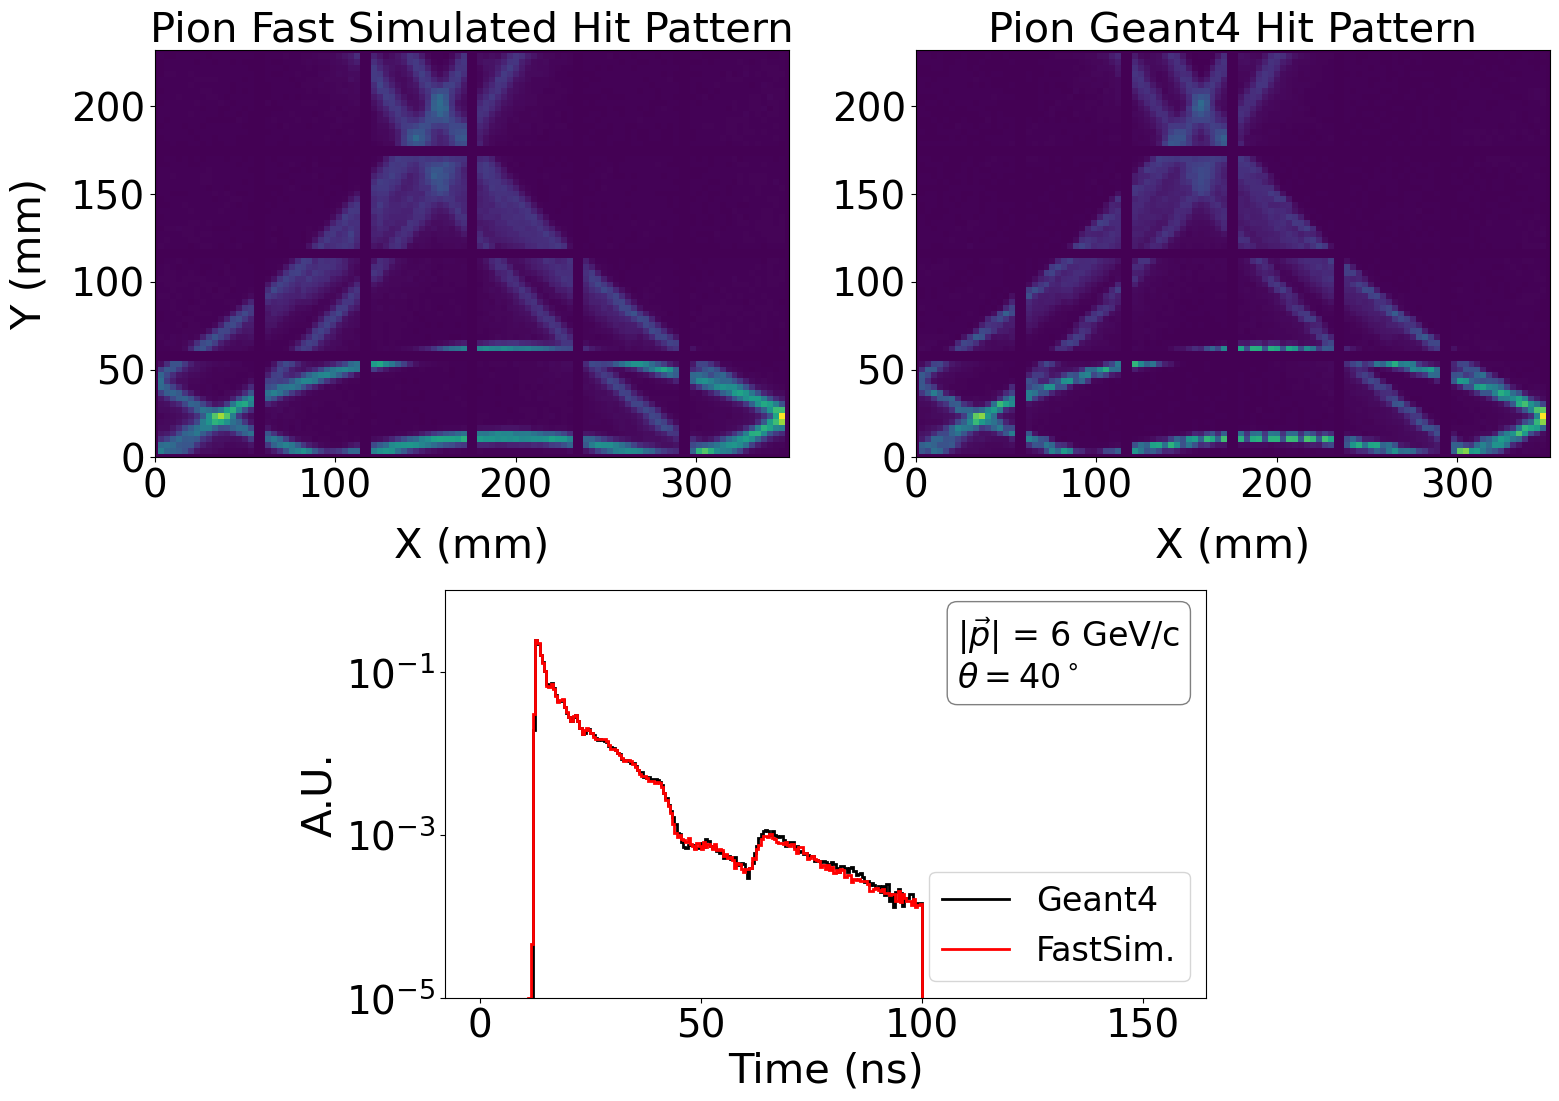

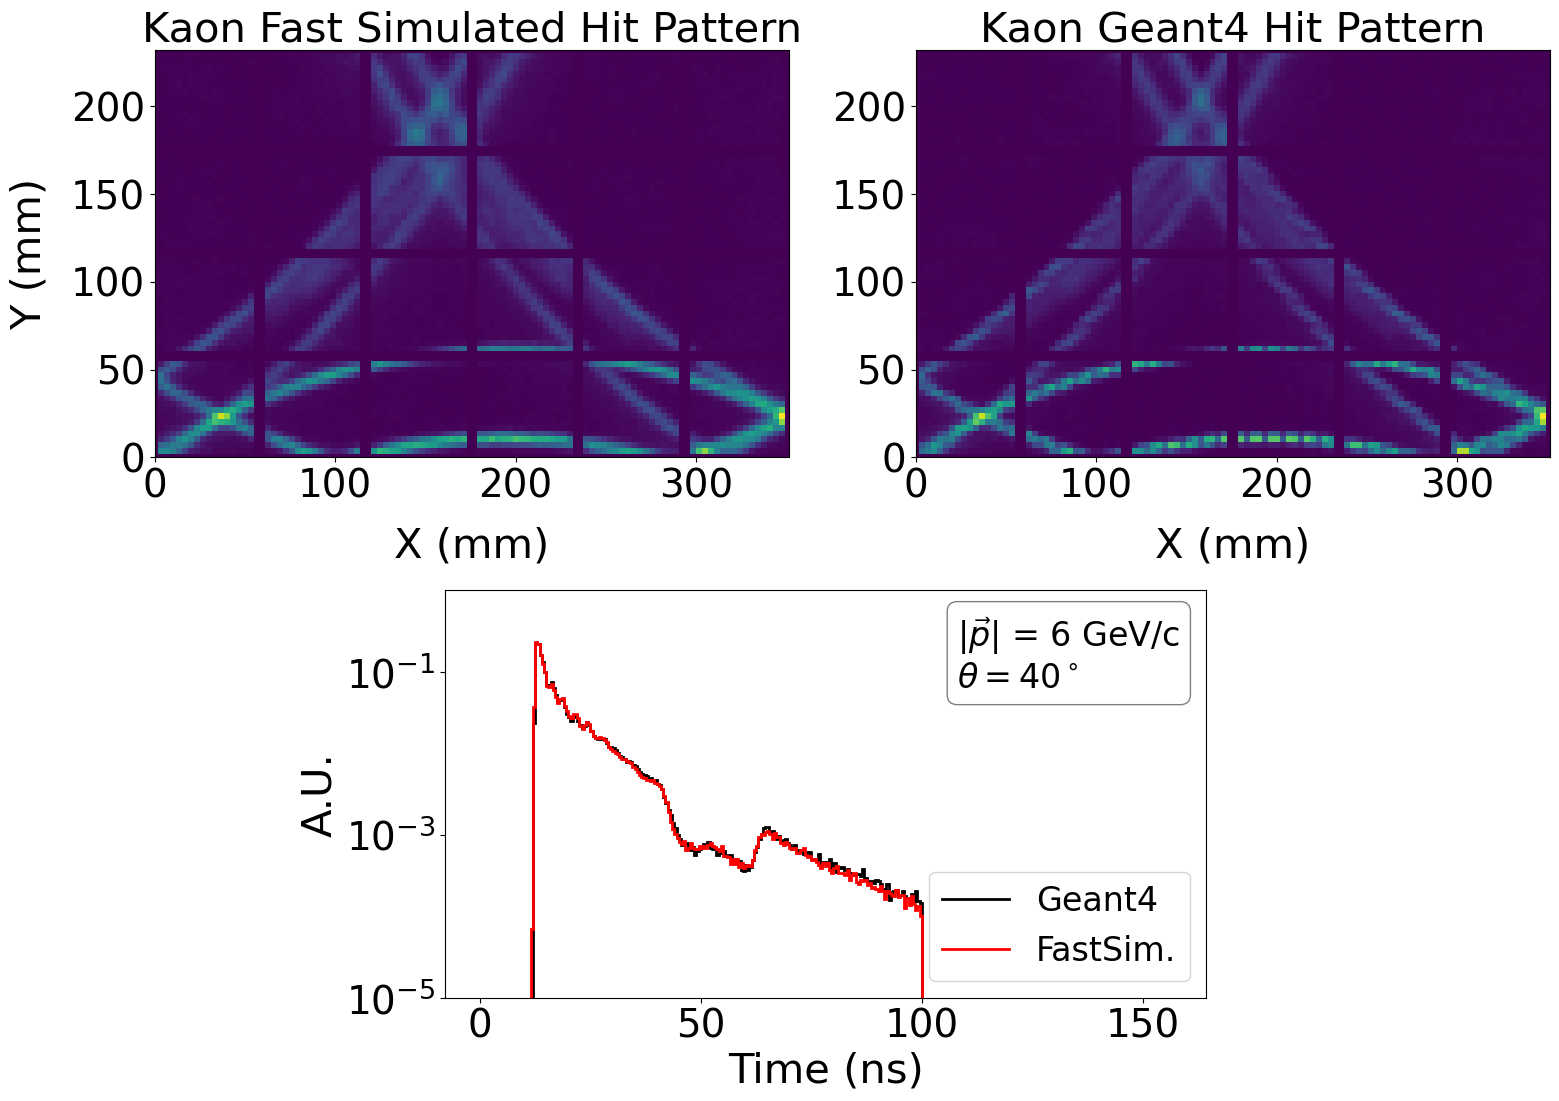

 
Making plots for theta =  100.0


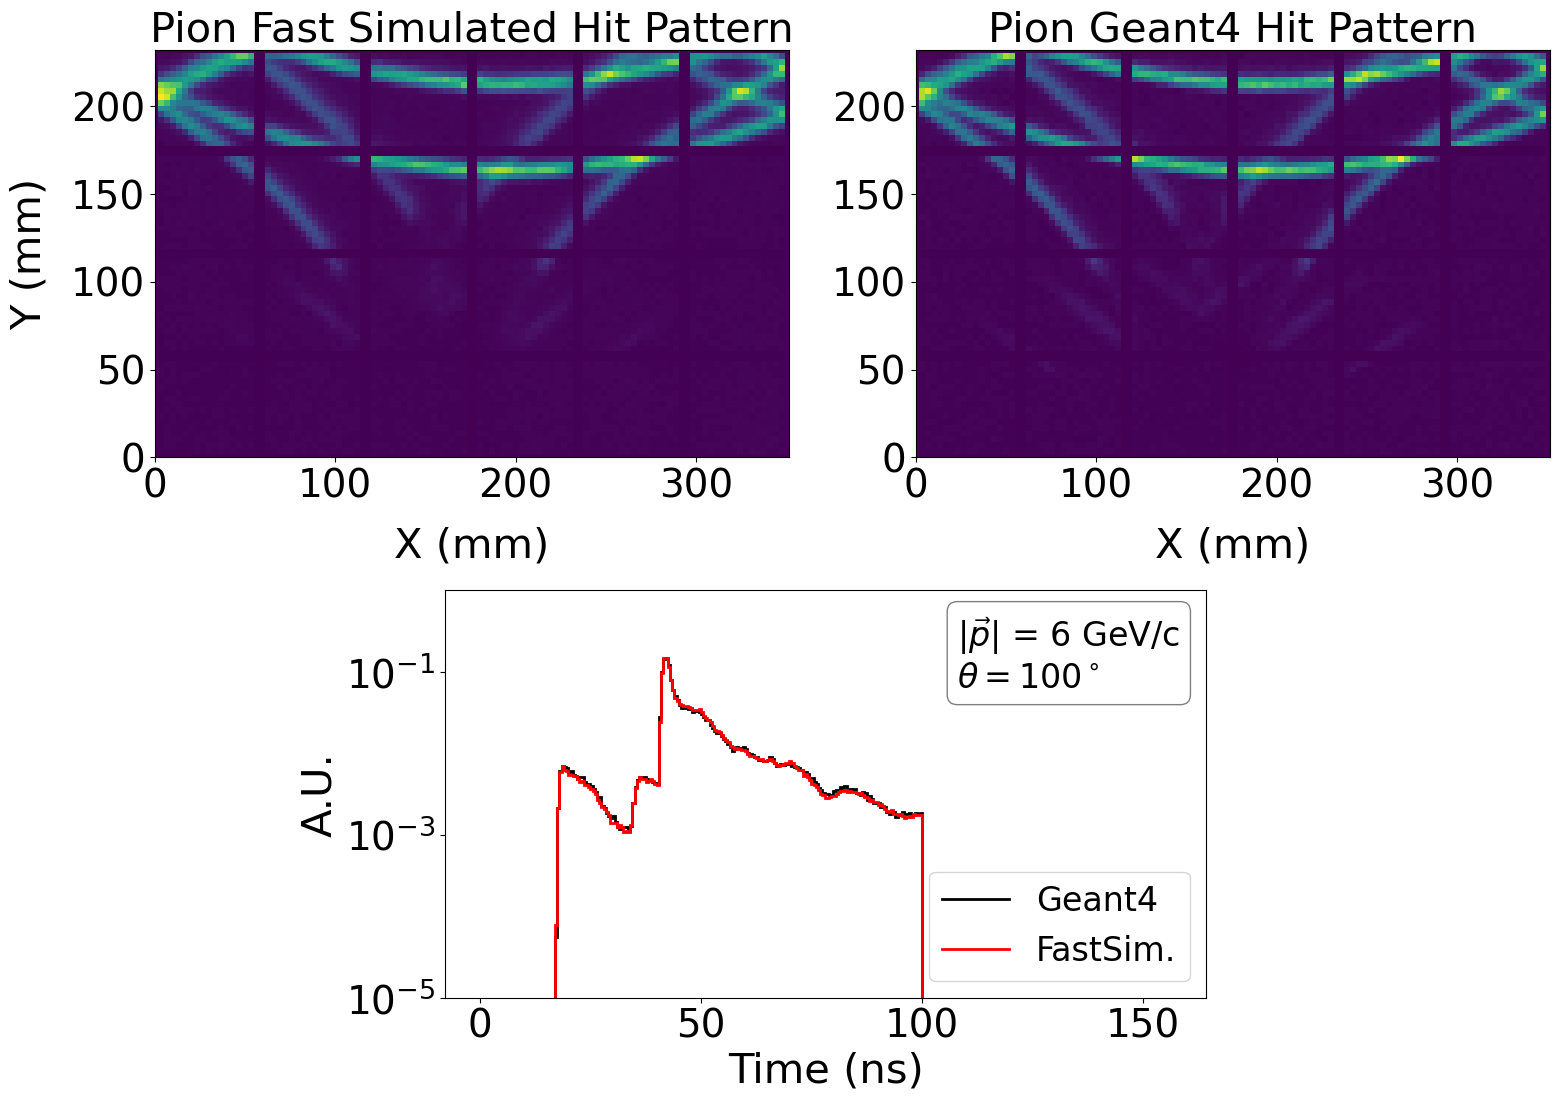

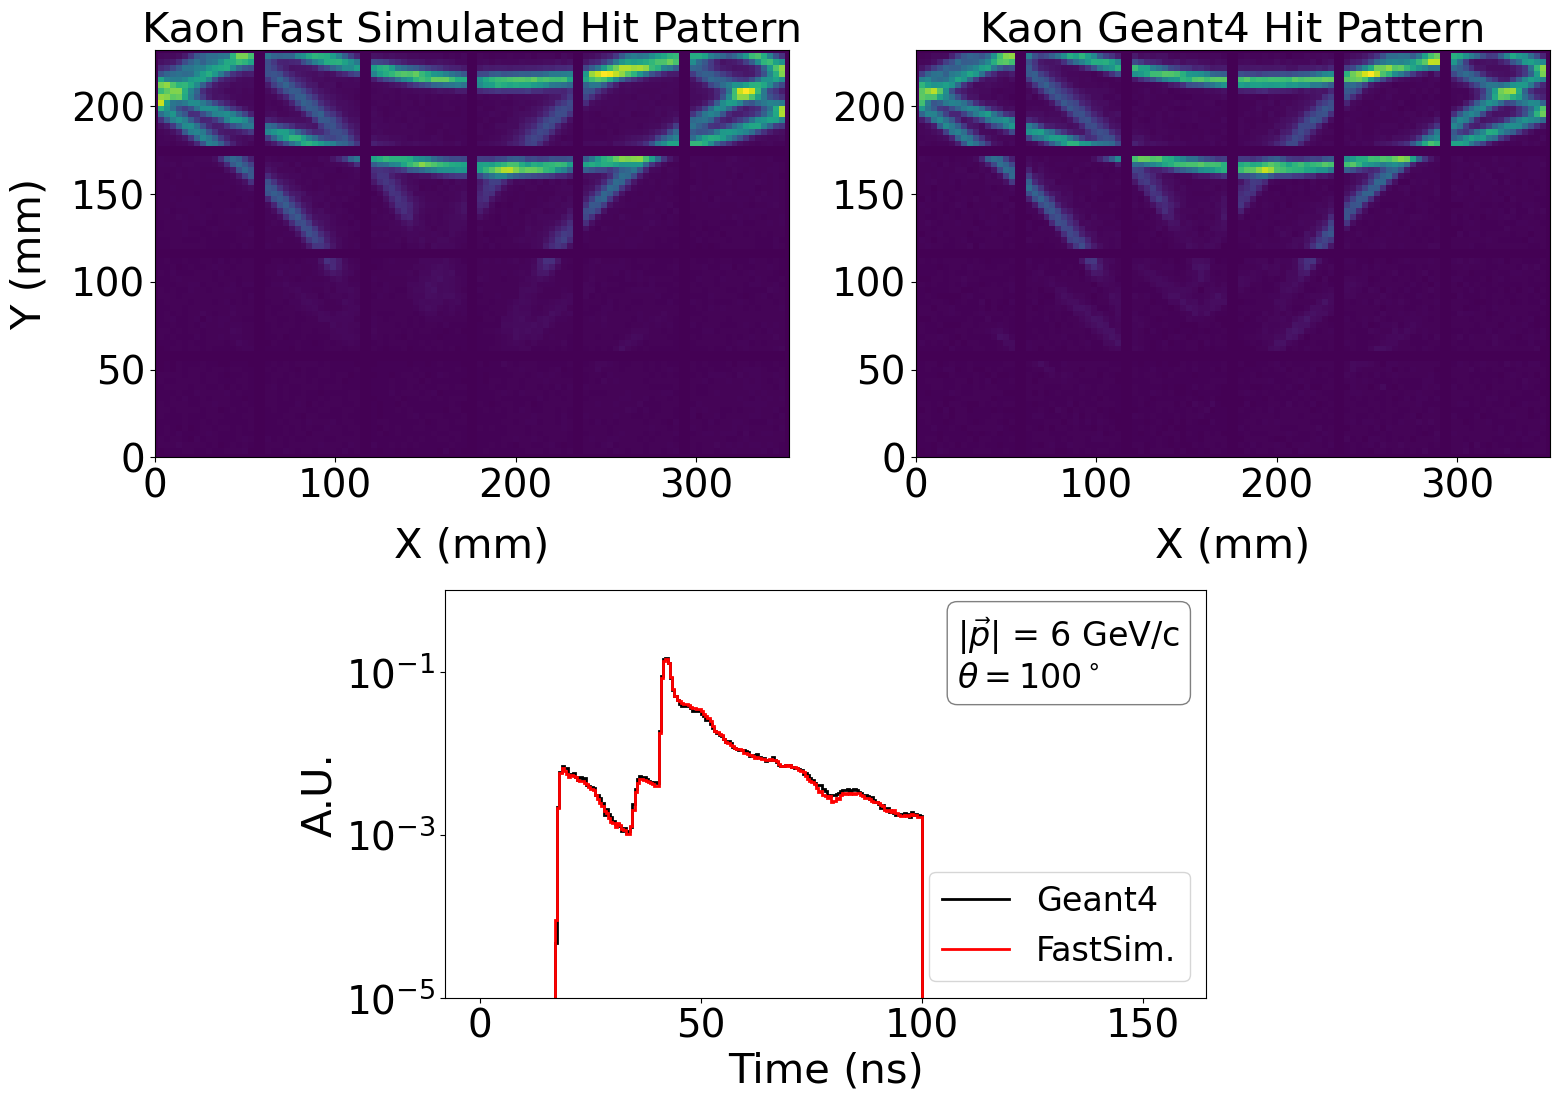

 
Making plots for theta =  130.0


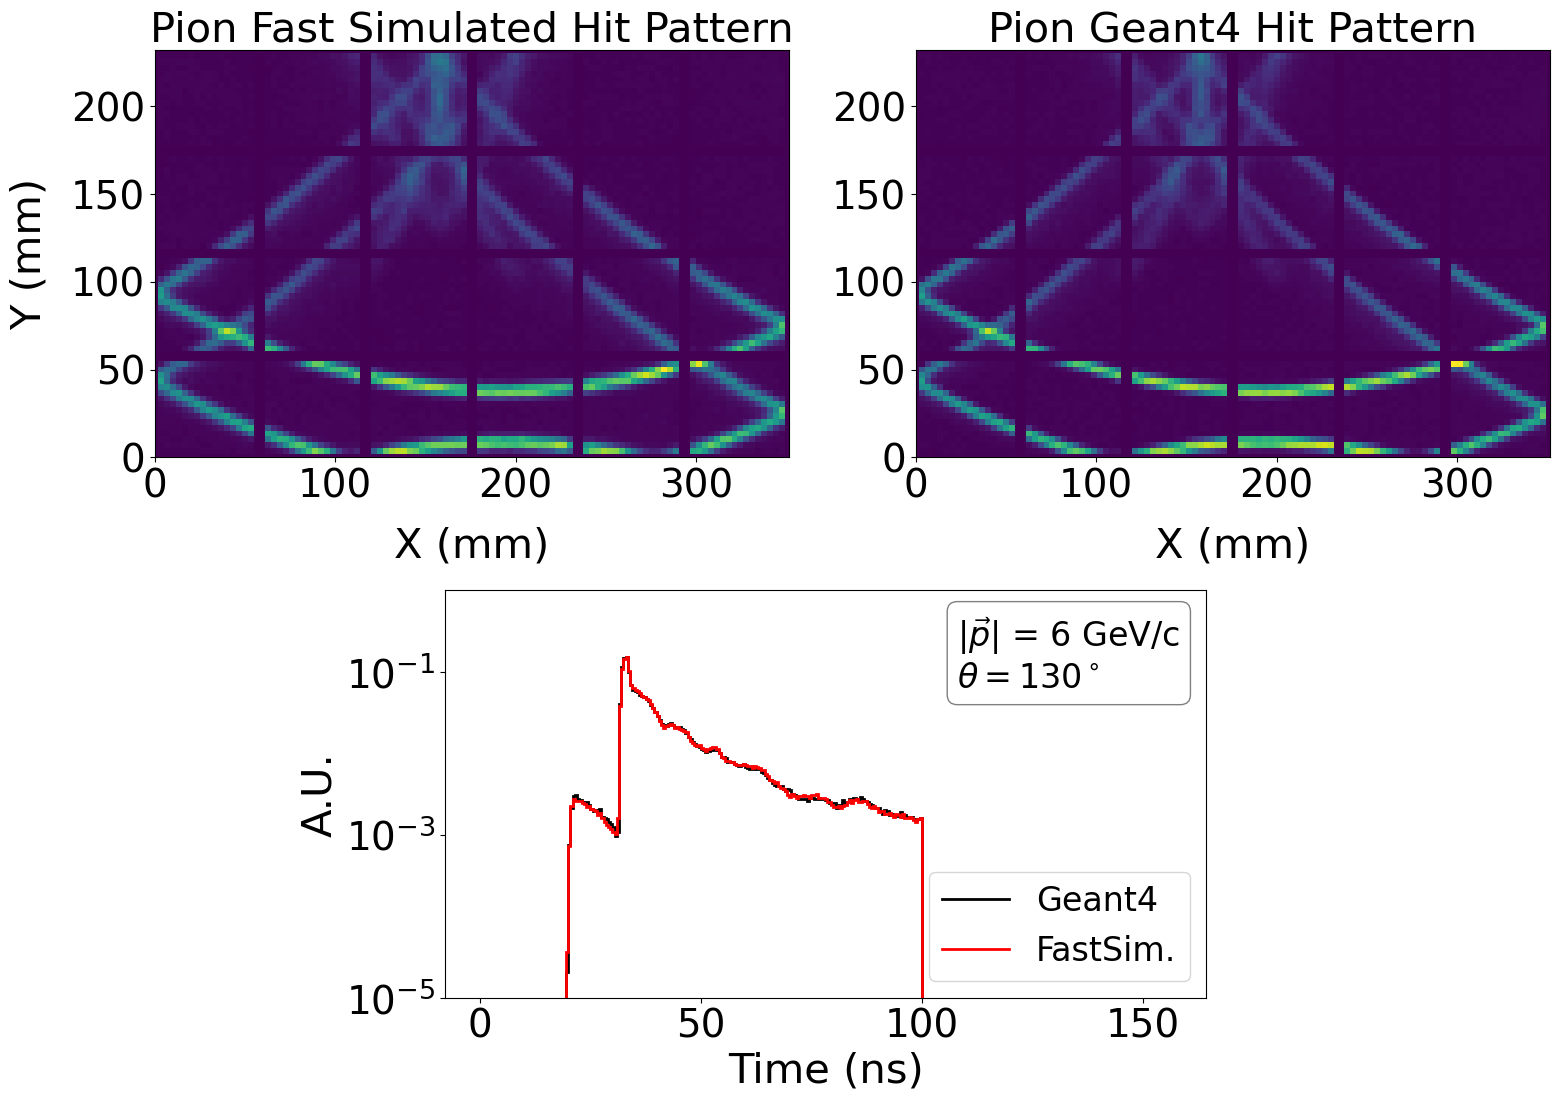

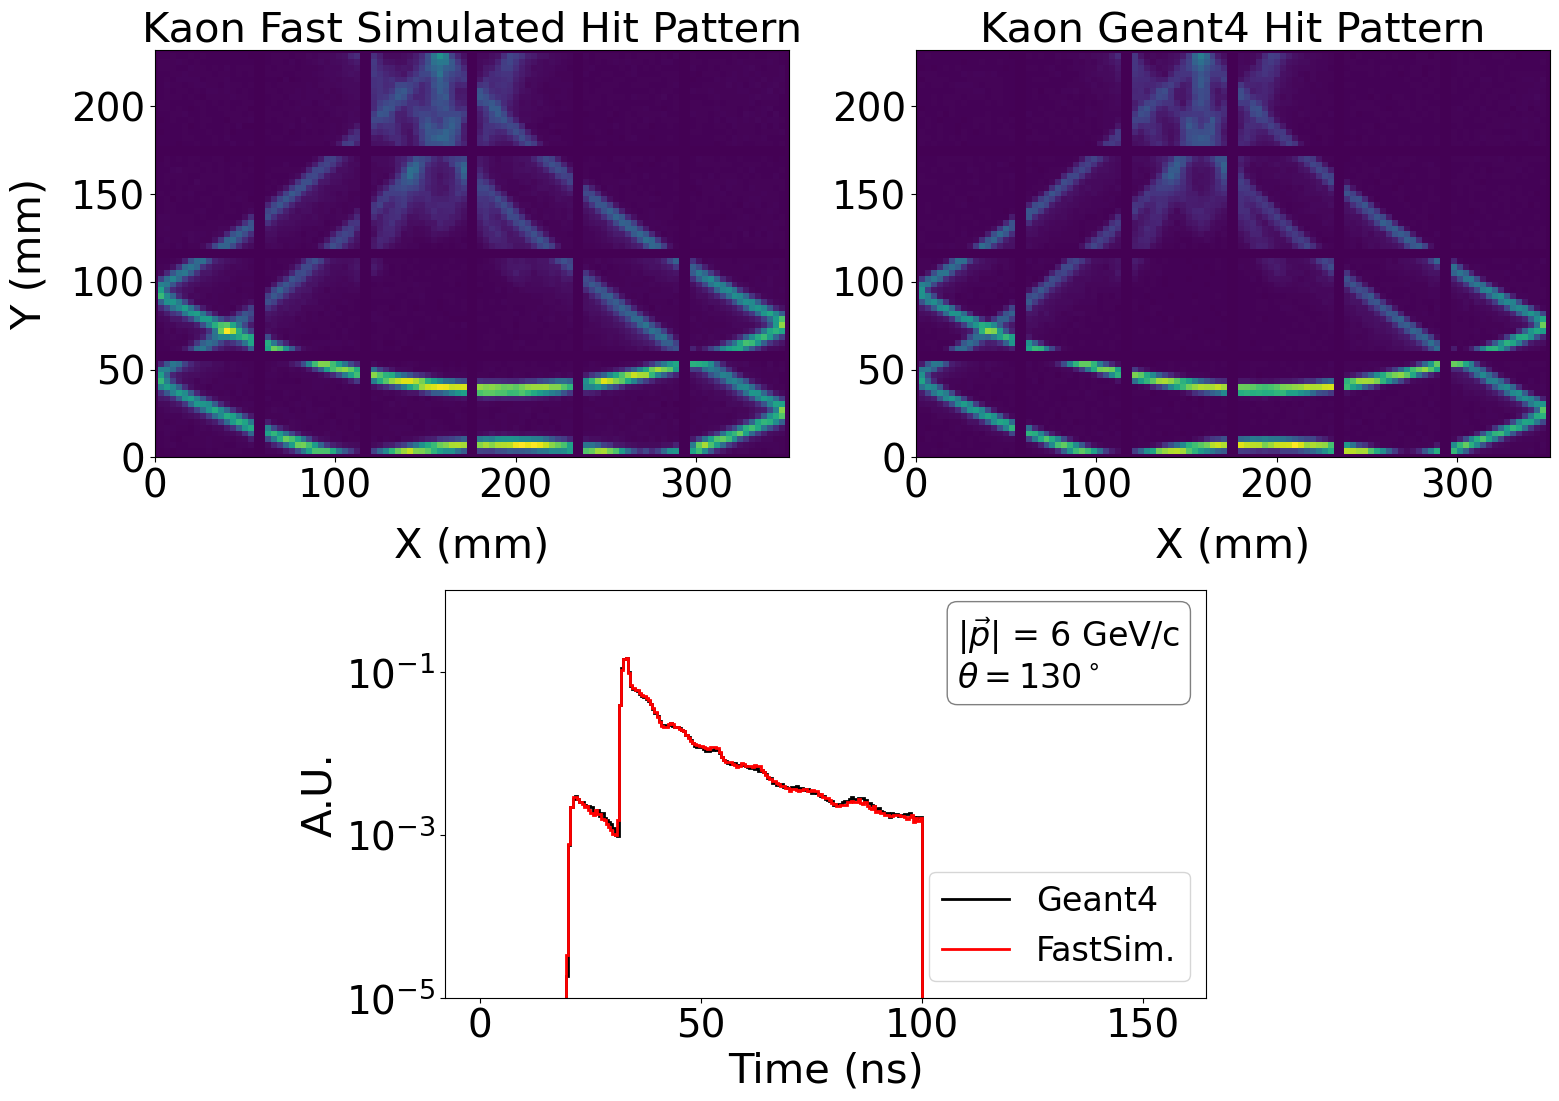

In [122]:
#thetas =  [30.,35.,40.,45.,50.,55.,60.,65.,70.,75.,80.,85.,90.,95.,100.,105.,110.,115.,120.,125.,130.,135.,140.,145.,150.] 
momentum = 6.0
log_norm = False
base_dir = f"KDE_Fits/{momentum}/Test_FastDIRC_800k_NF_800kG"
thetas = [40.,100.,130.]
for theta_ in thetas:
    print("Making plots for theta = ",theta_)
    try:
        geant_pions = np.load(os.path.join(base_dir,f"Geant_SupportPions_{theta_}.npy"))
        geant_kaons = np.load(os.path.join(base_dir,f"Geant_SupportKaons_{theta_}.npy"))
        fs_pions = np.load(os.path.join(base_dir,f"FastSim_SupportPions_{theta_}.npy"))
        fs_kaons = np.load(os.path.join(base_dir,f"FastSim_SupportKaons_{theta_}.npy"))
        h_fs_pion,h_g_pion = make_plots_fastsim(geant_pions,fs_pions,label='Pion',momentum=momentum,theta=theta_,log_norm=log_norm)
        h_fs_kaon,h_g_kaon = make_plots_fastsim(geant_kaons,fs_kaons,label='Kaon',momentum=momentum,theta=theta_,log_norm=log_norm)
    except:
        print("Something went wrong.")
        continue
    print(" ")

Making plots for theta =  40.0


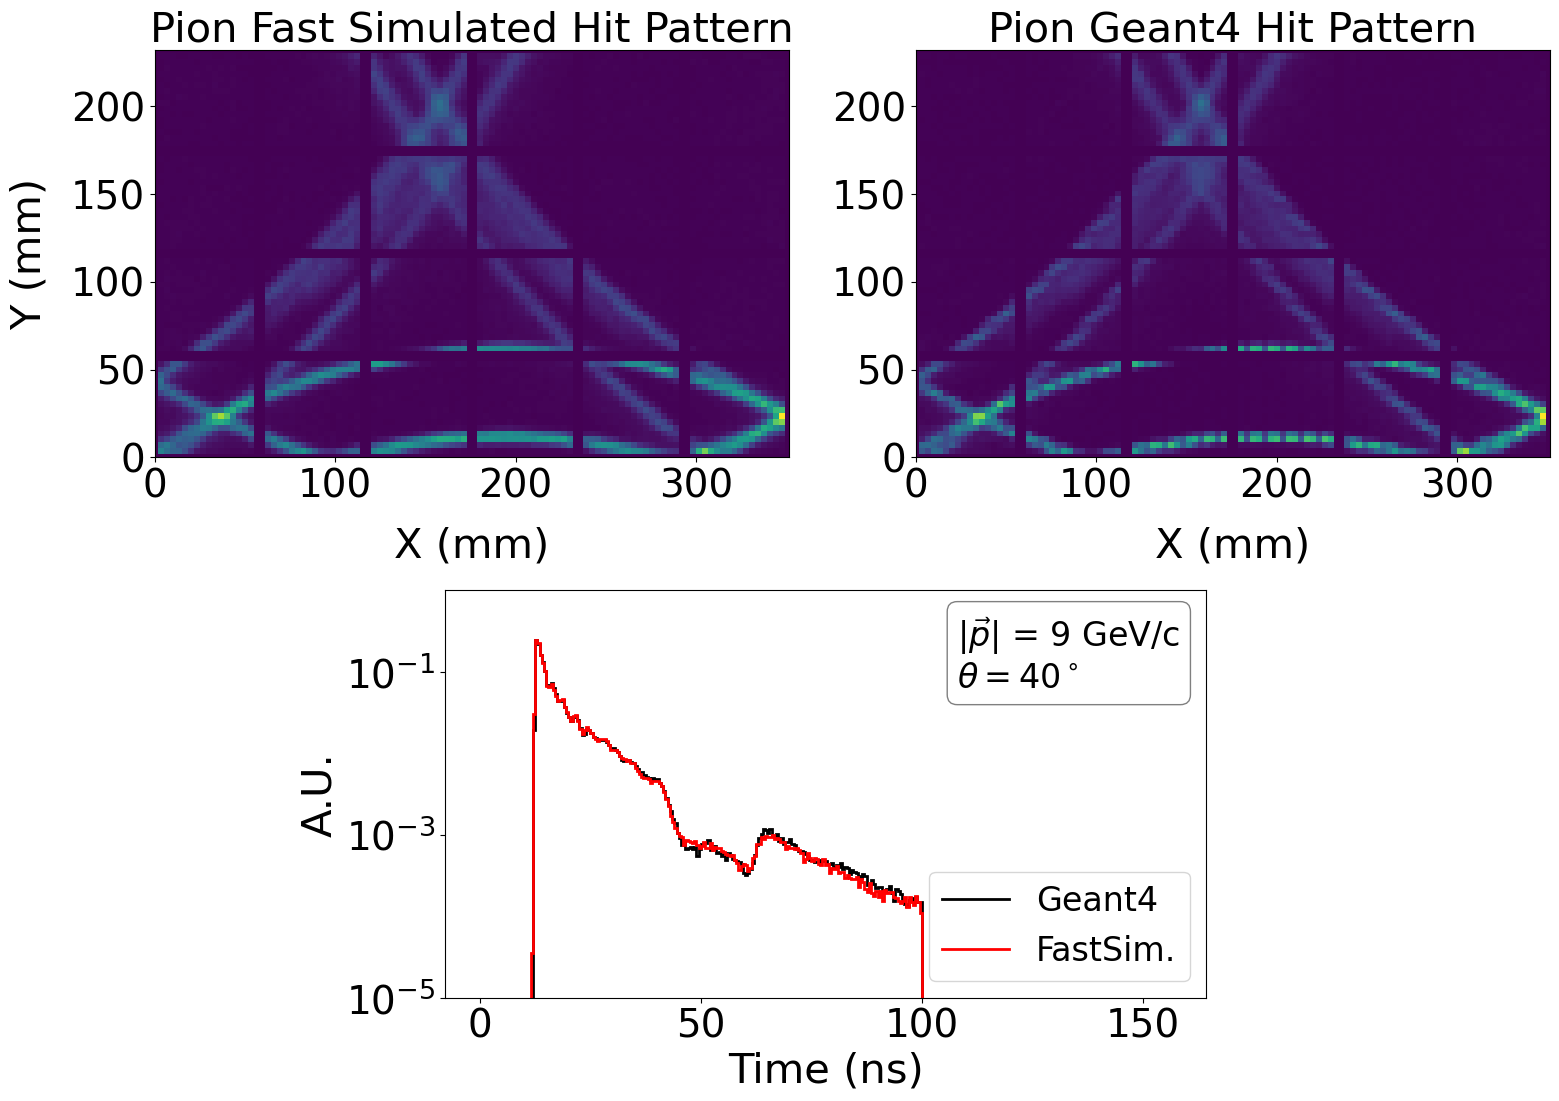

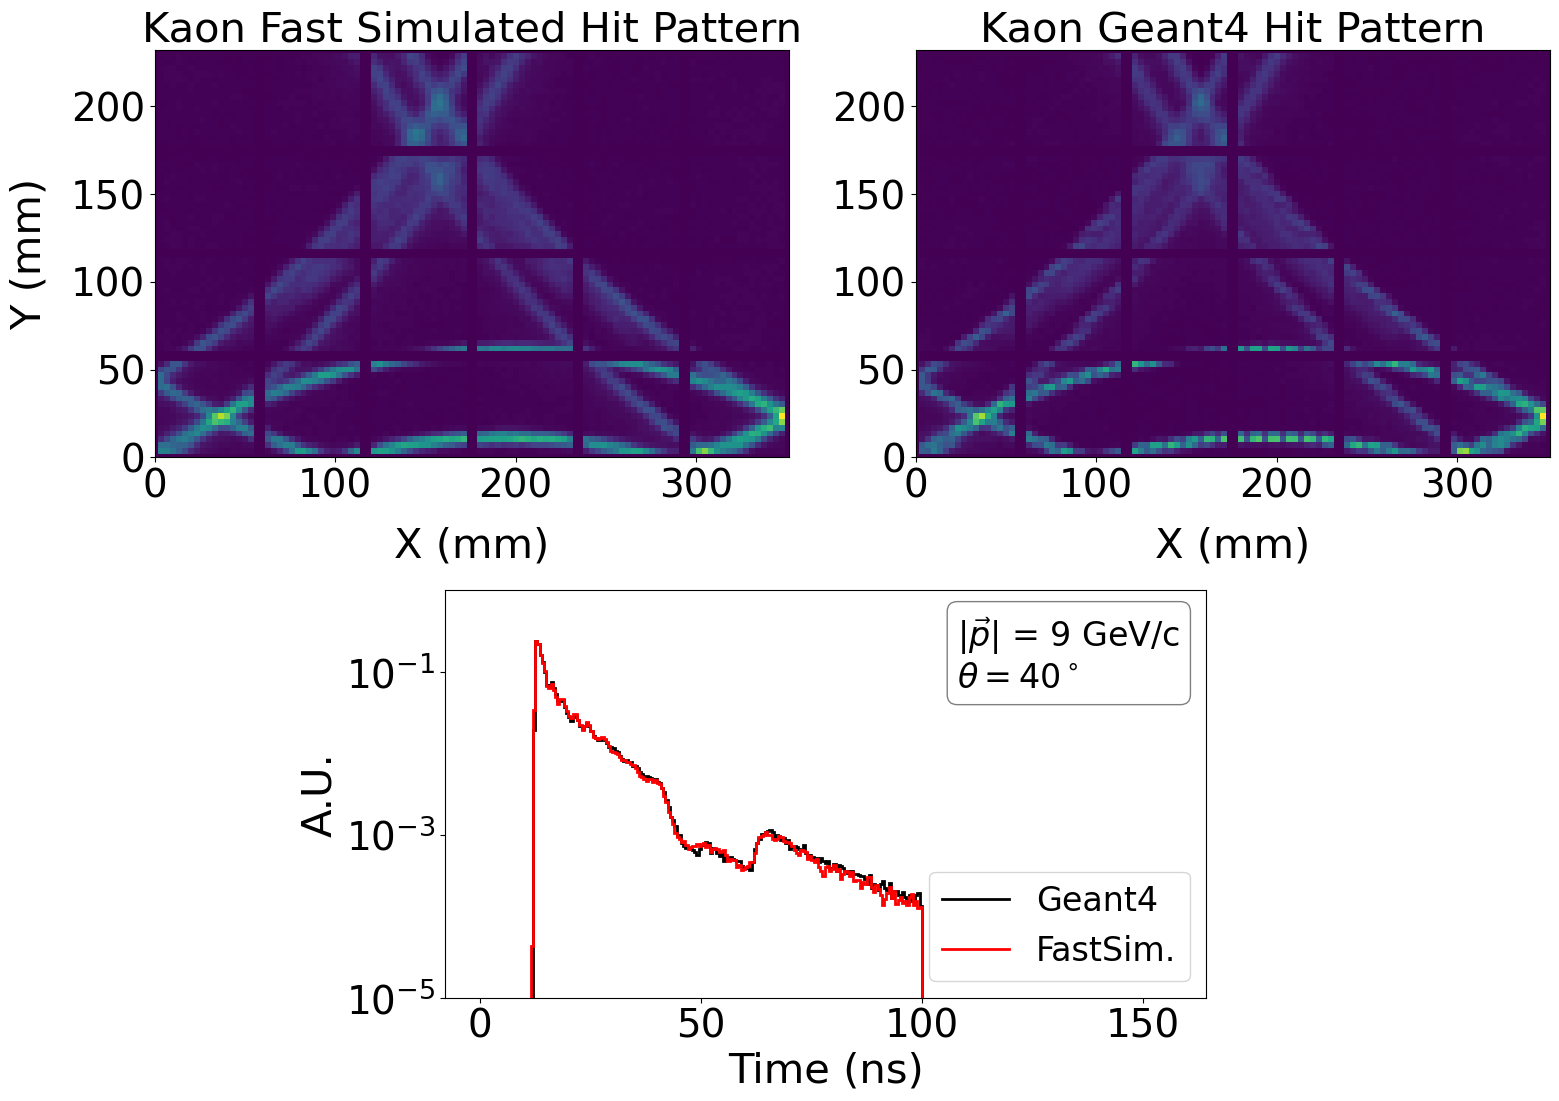

 
Making plots for theta =  100.0


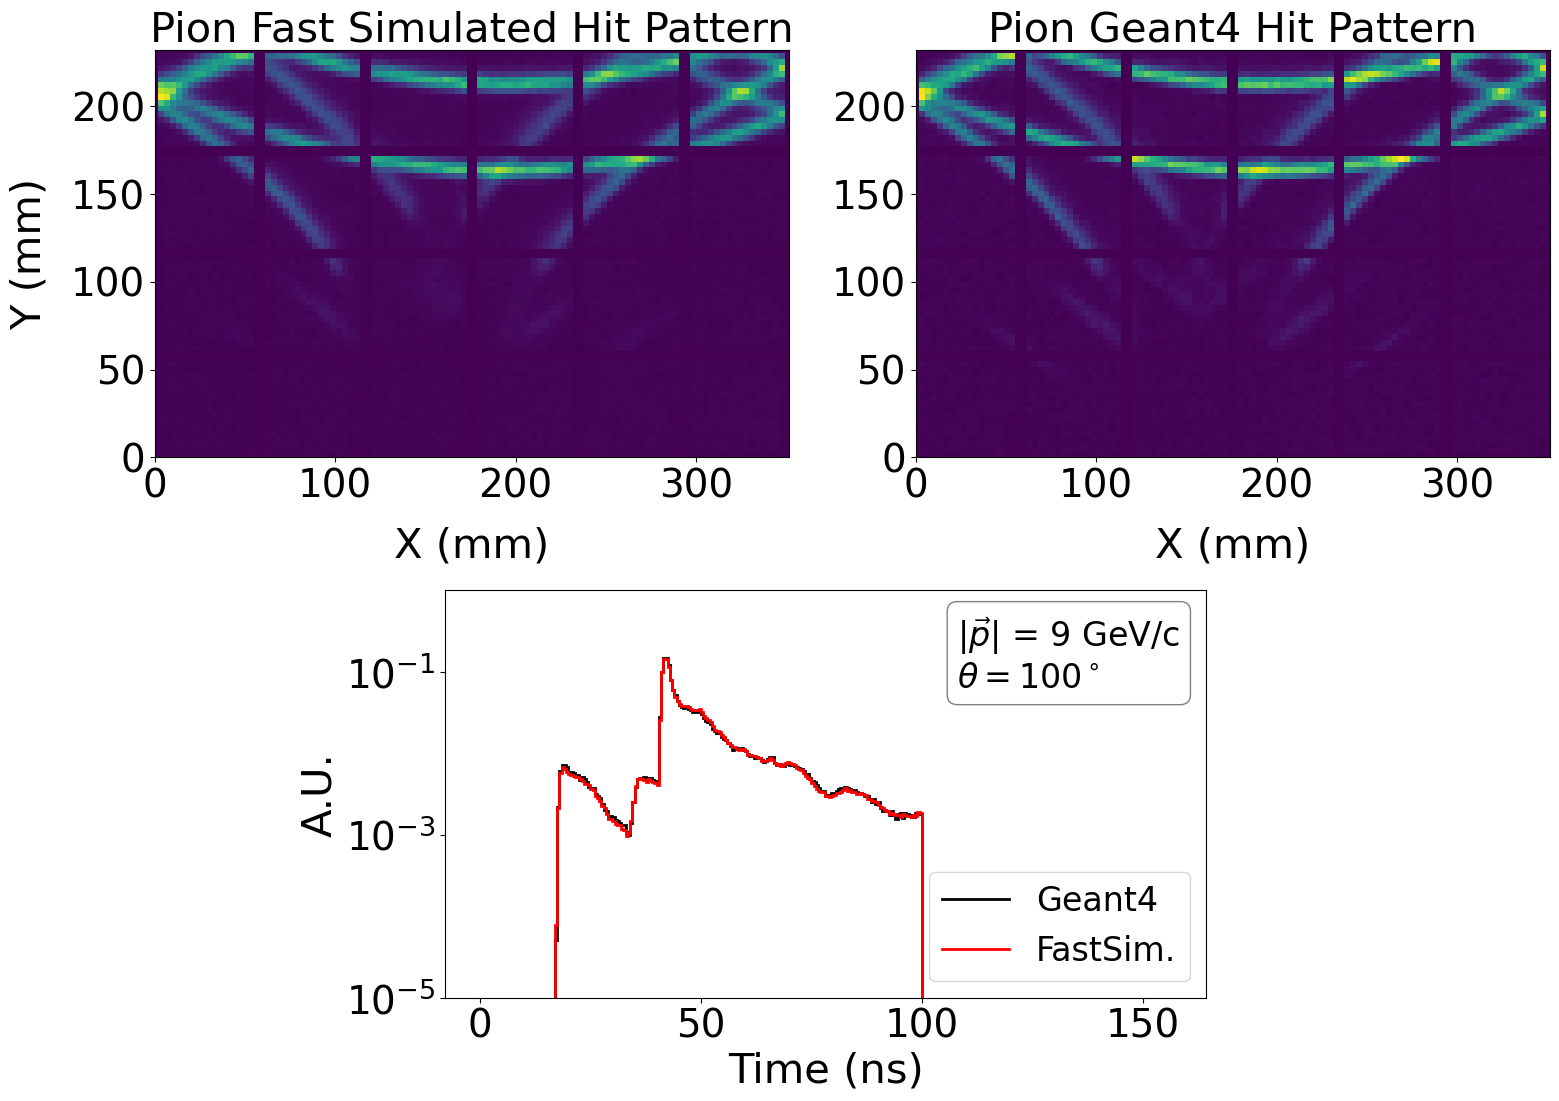

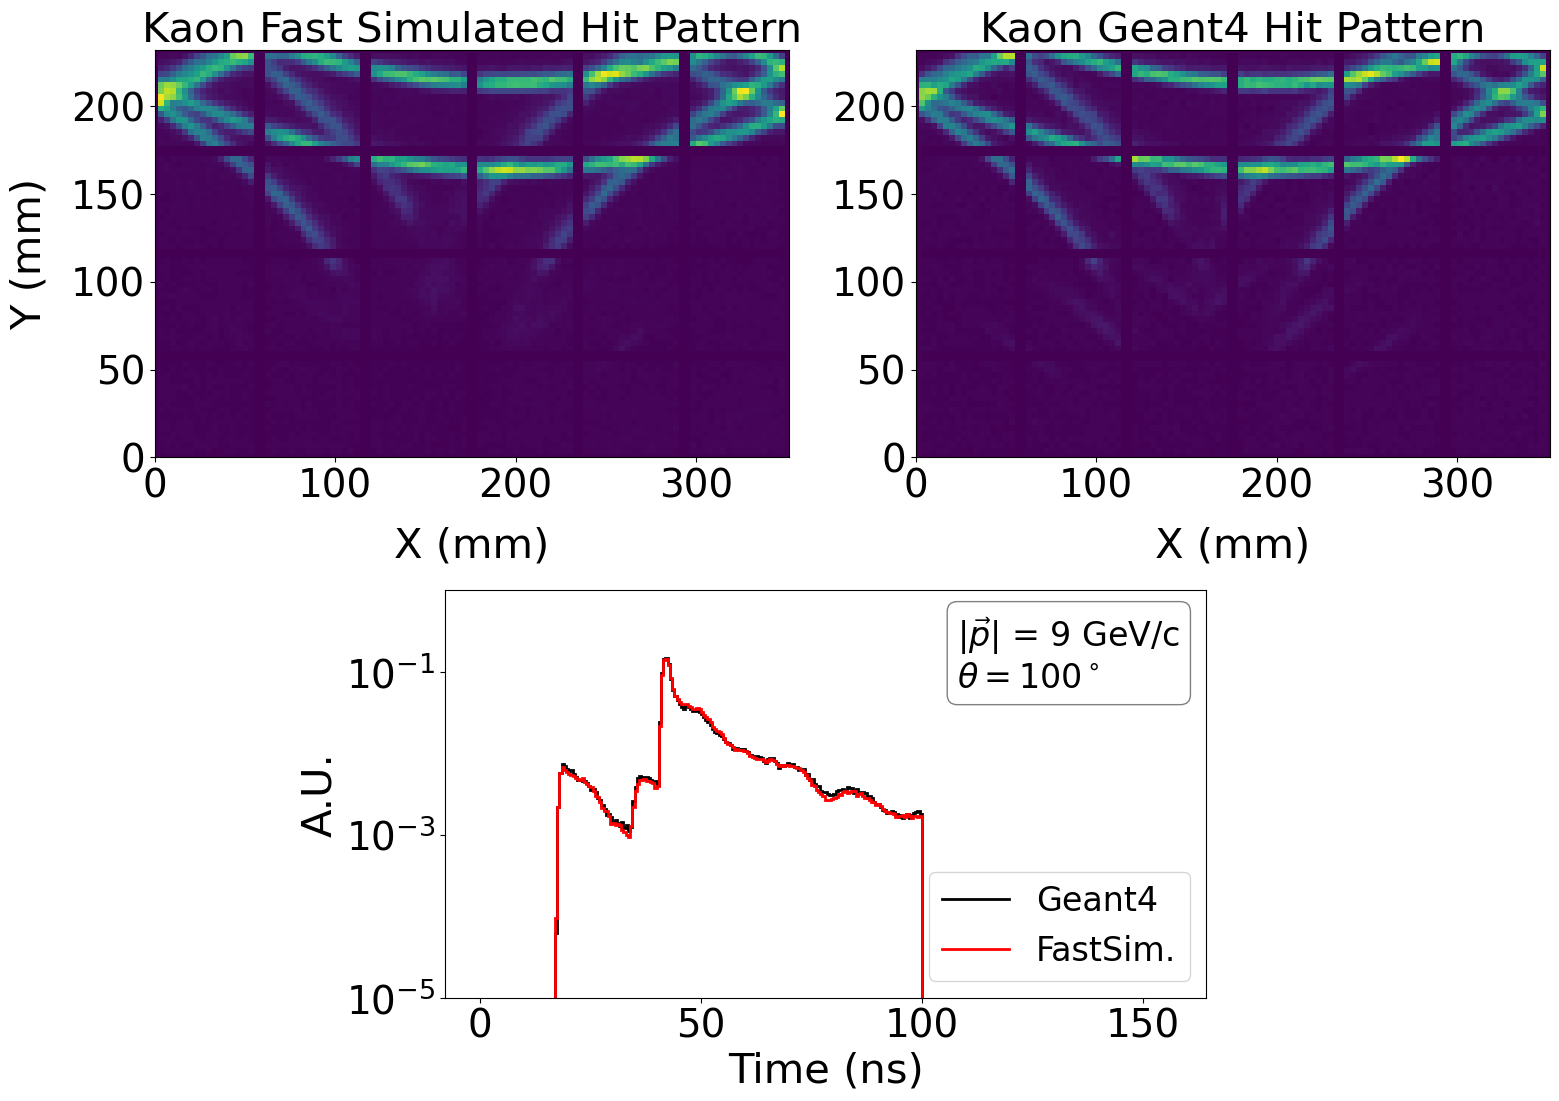

 
Making plots for theta =  130.0


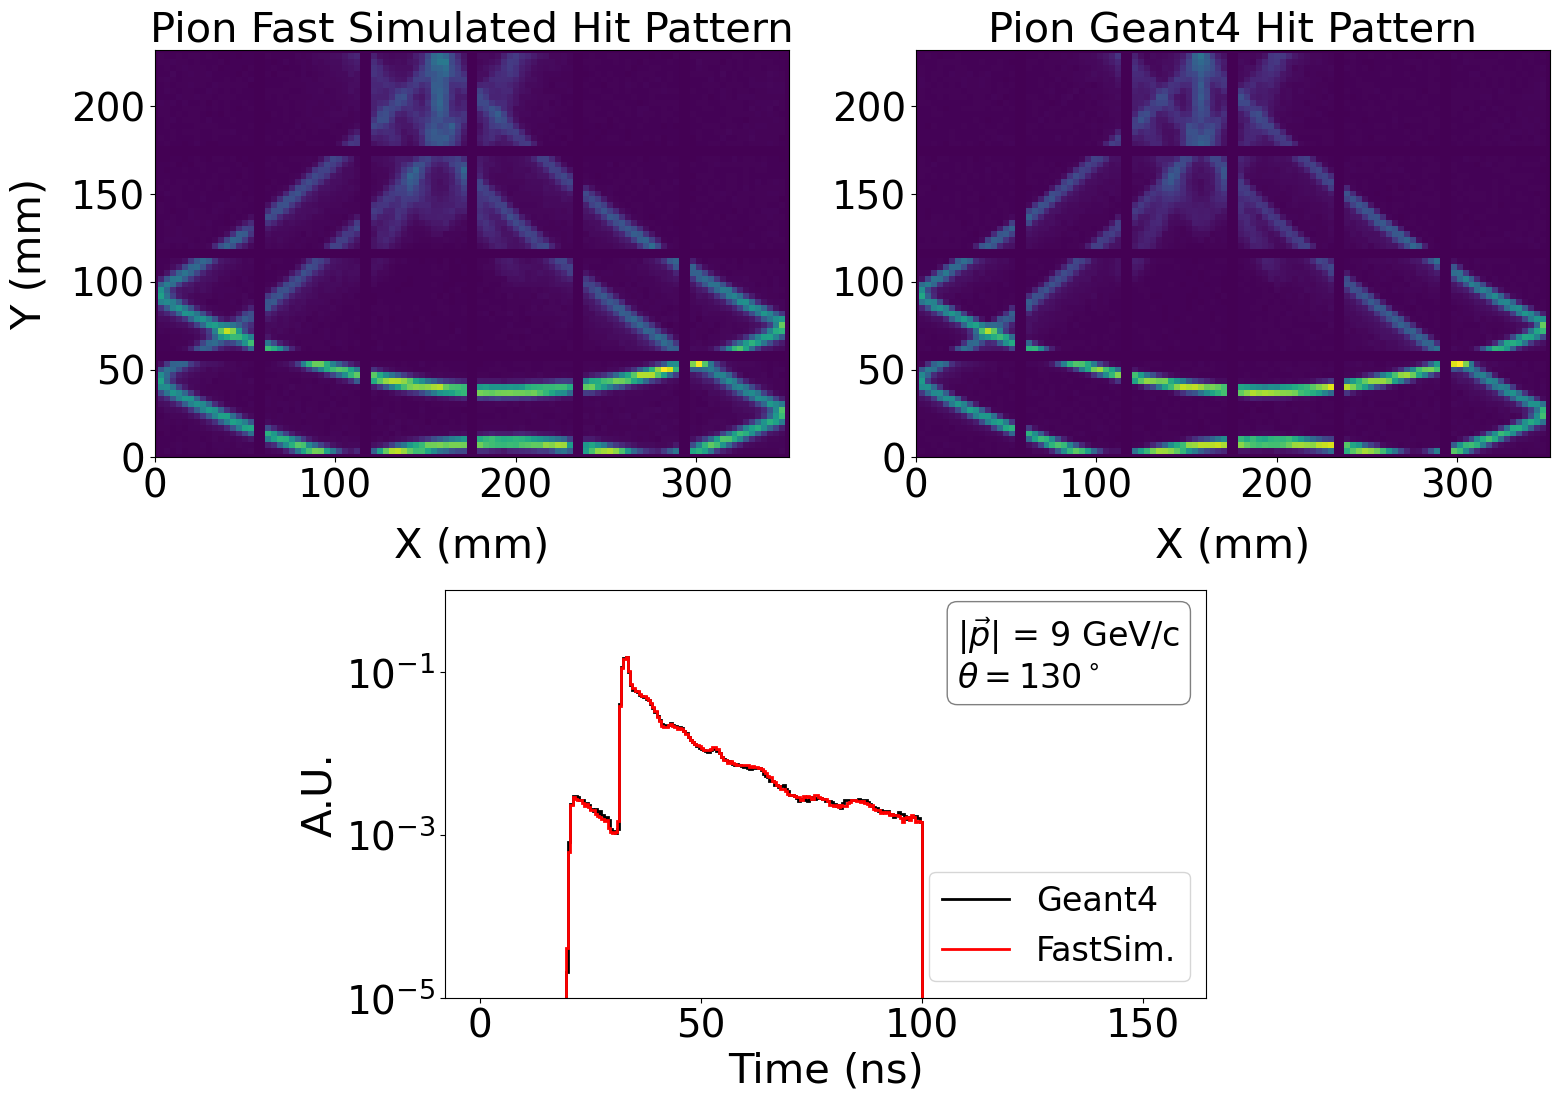

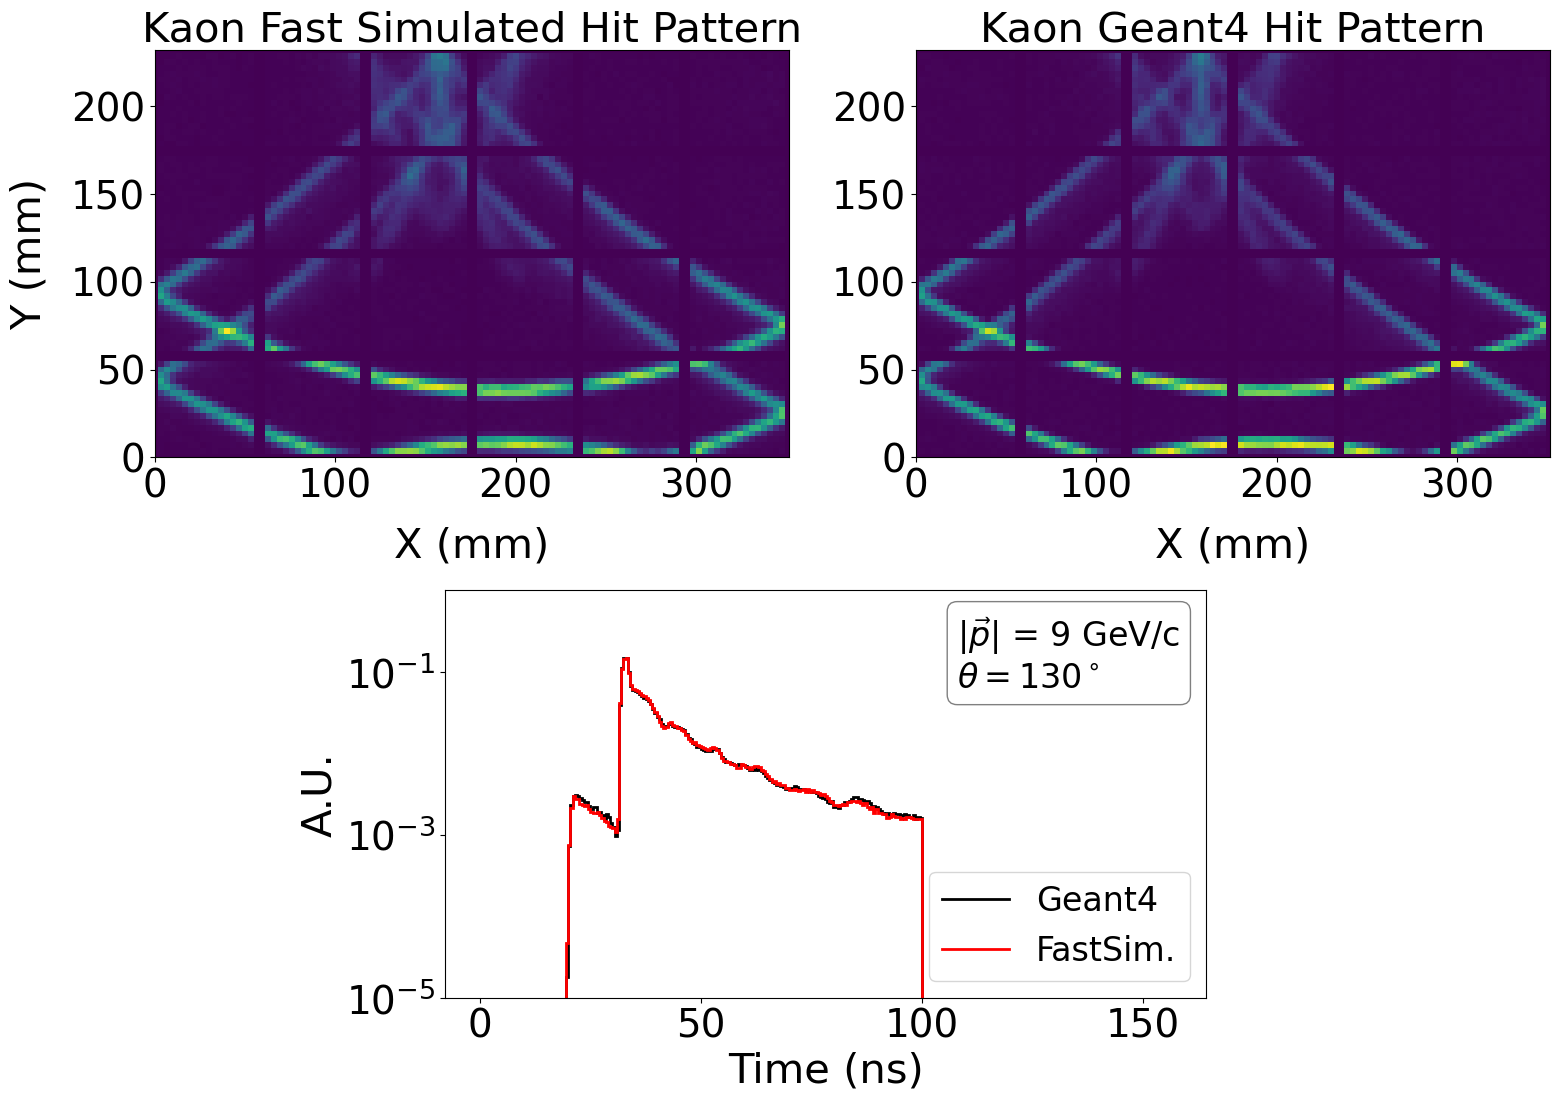

In [6]:
#thetas =  [30.,35.,40.,45.,50.,55.,60.,65.,70.,75.,80.,85.,90.,95.,100.,105.,110.,115.,120.,125.,130.,135.,140.,145.,150.] 
momentum = 9.0
log_norm = False
base_dir = f"KDE_Fits/{momentum}/Test_FastDIRC_800k_NF_800kG"
thetas = [40.,100.,130.]
for theta_ in thetas:
    print("Making plots for theta = ",theta_)
    try:
        geant_pions = np.load(os.path.join(base_dir,f"Geant_SupportPions_{theta_}.npy"))
        geant_kaons = np.load(os.path.join(base_dir,f"Geant_SupportKaons_{theta_}.npy"))
        fs_pions = np.load(os.path.join(base_dir,f"FastSim_SupportPions_{theta_}.npy"))
        fs_kaons = np.load(os.path.join(base_dir,f"FastSim_SupportKaons_{theta_}.npy"))
        h_fs_pion,h_g_pion = make_plots_fastsim(geant_pions,fs_pions,label='Pion',momentum=momentum,theta=theta_,log_norm=log_norm)
        h_fs_kaon,h_g_kaon = make_plots_fastsim(geant_kaons,fs_kaons,label='Kaon',momentum=momentum,theta=theta_,log_norm=log_norm)
    except:
        print("Something went wrong.")
        continue
    print(" ")

# Some Metrics

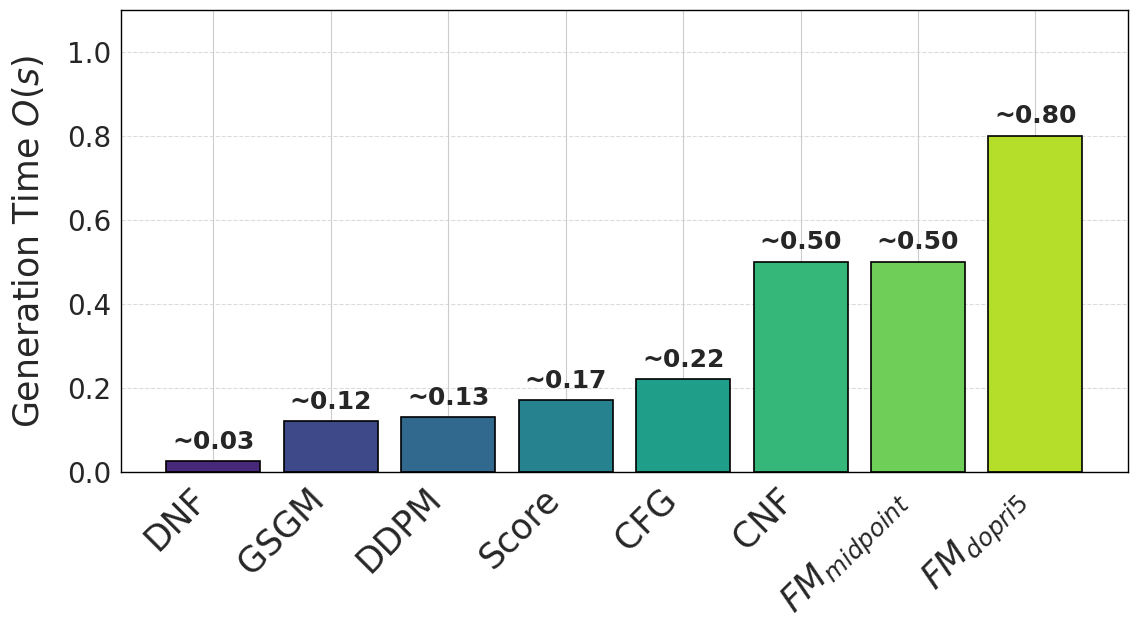

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")

# dictionary with methods and times
dicte_ = {"DNF": 0.032,
          r'DDPM_{T=100}': 0.239,
          "GSGM": 0.240,
          "Score": 0.354,
          r'$FM_{midpoint}$': 0.422,
          r'DDPM_{T=200}': 0.488,
          "CNF": 0.510
}


labels = list(dicte_.keys())
heights = list(dicte_.values())

colors = sns.color_palette("viridis", len(labels))

plt.figure(figsize=(13, 6))
bars = plt.bar(labels, heights, color=colors, edgecolor='black', linewidth=1.2)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
             f'~{bar.get_height():.2f}', ha='center', fontsize=18, fontweight='bold')


plt.ylim(0, 1.1)  # Extra space for labels
plt.xticks(rotation=45, fontsize=25, ha="right")  
plt.yticks(fontsize=20)
plt.ylabel(r"Generation Time $O(s)$", fontsize=25, labelpad=15)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for spine in plt.gca().spines.values():
    spine.set_color('black')  
    spine.set_linewidth(1.)  

#plt.savefig("Generation_Time_Comparison.pdf",bbox_inches="tight")
plt.show()


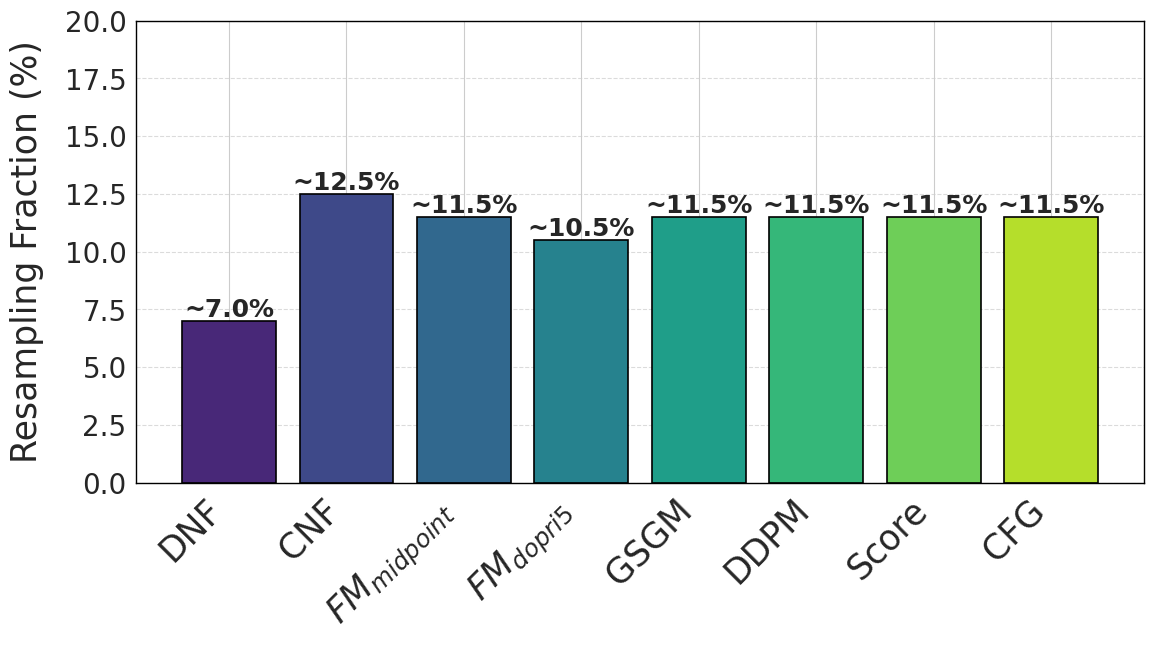

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# dictionary with methods and resampling fractions
dicte_ = {"DNF": "5-9%",
          "CNF": "10-15%",
          r'$FM_{midpoint}$': "10-13%",
          r'$FM_{dopri5}$': "9-12%",
          "GSGM": "10-13%",
          'DDPM': "10-13%",
          "Score": "10-13%",
          "CFG": "10-13%"}


def parse_fraction(fraction_str):
    lower, upper = fraction_str.split('-')
    lower_value = float(lower.replace('%', '')) 
    upper_value = float(upper.replace('%', '')) 
    average_value = (lower_value + upper_value) / 2
    return lower_value, upper_value, average_value

labels = list(dicte_.keys())
lower_values = []
upper_values = []
averages = []

for key in dicte_.keys():
    lower, upper, average = parse_fraction(dicte_[key])
    lower_values.append(lower)
    upper_values.append(upper)
    averages.append(average)


colors = sns.color_palette("viridis", len(labels))

plt.figure(figsize=(13, 6))

bars = plt.bar(labels, averages, color=colors, edgecolor='black', linewidth=1.2)

for bar, upper, average in zip(bars, upper_values, averages):
    text_position = bar.get_height() + 0.2  
    plt.text(bar.get_x() + bar.get_width()/2, text_position,
             f'~{average:.1f}%', ha='center', fontsize=18, fontweight='bold')

plt.ylim(0, 20)  
plt.xticks(rotation=45, fontsize=25, ha="right")  
plt.yticks(fontsize=20)
plt.ylabel(r"Resampling Fraction (%)", fontsize=25, labelpad=15)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for spine in plt.gca().spines.values():
    spine.set_color('black')  
    spine.set_linewidth(1.)  

# Show the plot
#plt.savefig("Resampling_Fraction_Comparison.pdf",bbox_inches="tight")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")

# dictionary with methods and times
dicte_ = {"DNF": 1.914773327963693e-06,
          r'DDPM_{T=100}': 1.4250596932002476e-05,
          "GSGM": 1.4168384415762766e-05,
          "Score": 2.1123785291399275e-05,
          r'$FM_{midpoint}$': 4.3492001465388706e-05,
          "CNF": 8.444329125540597e-05,
          "Geant": 0.00203049446
}


labels = list(dicte_.keys())
heights = list(dicte_.values())

colors = sns.color_palette("viridis", len(labels))

plt.figure(figsize=(13, 6))
bars = plt.bar(labels, heights, color=colors, edgecolor='black', linewidth=1.2)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
             f'~{bar.get_height():.2f}', ha='center', fontsize=18, fontweight='bold')


plt.ylim(0, 1.1)  # Extra space for labels
plt.xticks(rotation=45, fontsize=25, ha="right")  
plt.yticks(fontsize=20)
plt.ylabel(r"Generation Time $O(s)$", fontsize=25, labelpad=15)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for spine in plt.gca().spines.values():
    spine.set_color('black')  
    spine.set_linewidth(1.)  

#plt.savefig("Generation_Time_Comparison.pdf",bbox_inches="tight")
plt.show()


In [4]:
geant.keys()

dict_keys(['eff', 'rej', 'auc'])

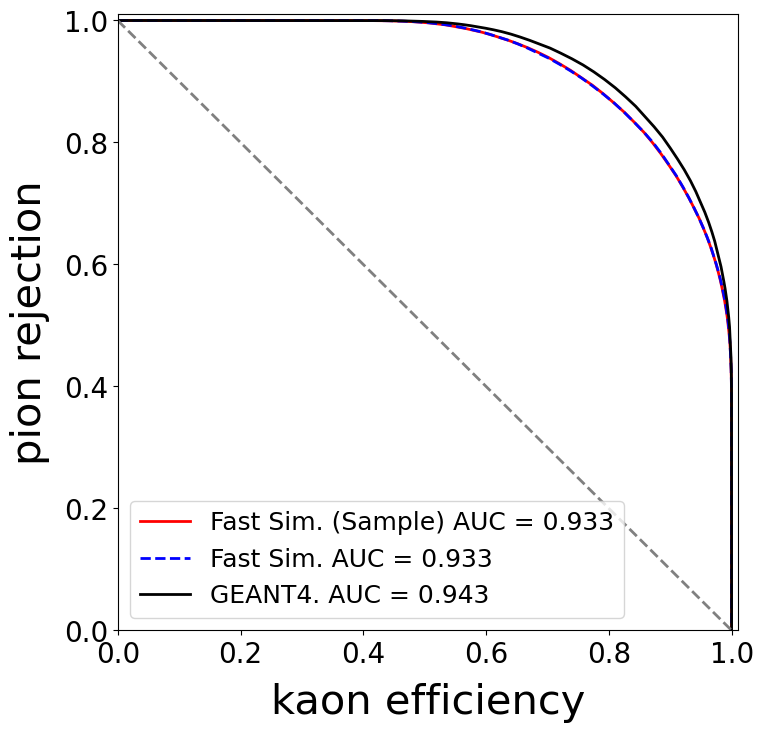

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ROC Curve
fast_sim = np.load("Inference/NF_PhotonSampling/ROC_AUC_FastSim.pkl",allow_pickle=True)
geant = np.load("Inference/NF_PhotonSampling/ROC_AUC_Geant.pkl",allow_pickle=True)
fs_no_sample = np.load("Inference/NF_NoSampling/ROC_AUC_FastSim.pkl",allow_pickle=True)

plt.figure(figsize=(8,8))
#plt.plot(rejections_geom,efficiencies_geom, color='blue', lw=2, label='Geometric Method. AUC = %0.3f' % auc_geom)
plt.plot(fast_sim['rej'],fast_sim['eff'],color='red', lw=2, label='Fast Sim. (Sample) AUC = %0.3f' % fast_sim['auc'])
plt.plot(fs_no_sample['rej'],fs_no_sample['eff'],color='blue', lw=2, label='Fast Sim. AUC = %0.3f' % fs_no_sample['auc'],linestyle='--')
plt.plot(geant['rej'],geant['eff'],color='k', lw=2, label='GEANT4. AUC = %0.3f' % geant['auc'])
plt.plot([0, 1], [1, 0], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel(r'kaon efficiency',fontsize=30,labelpad=10)
plt.ylabel(r'pion rejection',fontsize=30,labelpad=10) 
plt.legend(loc="lower left",fontsize=18)
plt.xticks(fontsize=20)  # adjust fontsize as needed
plt.yticks(fontsize=20)
out_path_DLL_ROC = f"Inference/DLL_piK_ROC_Comparison_Sample.pdf"
plt.savefig(out_path_DLL_ROC,bbox_inches='tight')
plt.show()

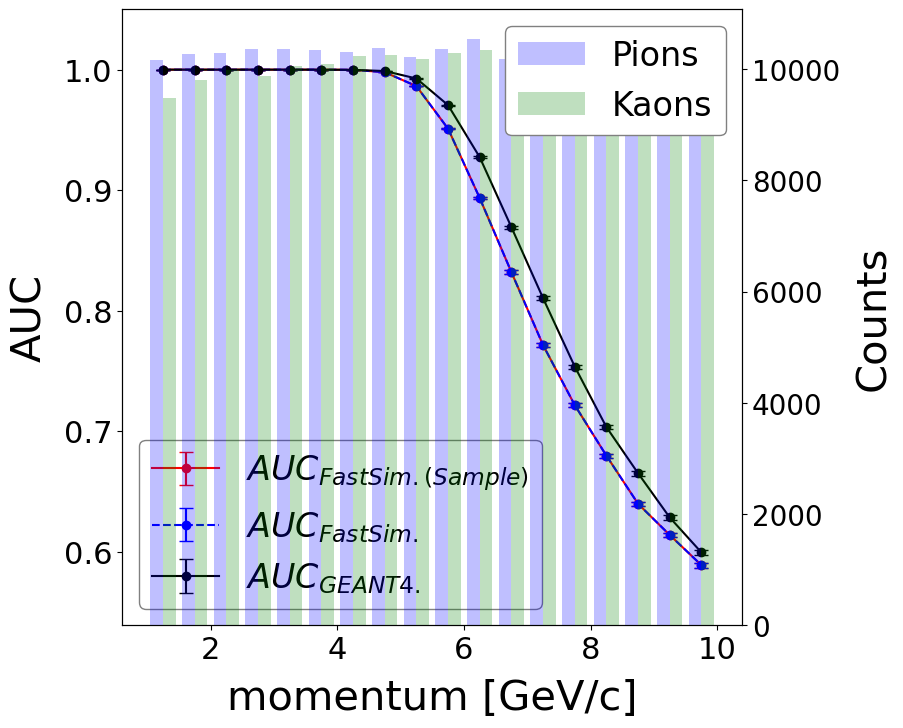

In [10]:
fast_sim = np.load("Inference/NF_PhotonSampling/DLL_Auc_func_P_FastSim.pkl",allow_pickle=True)
geant = np.load("Inference/NF_PhotonSampling/DLL_Auc_func_P_Geant.pkl",allow_pickle=True)
fs_no_sampling = np.load("Inference/NF_NoSampling/DLL_Auc_func_P_Geant.pkl",allow_pickle=True)
mom_ranges = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0]
centers = [mr+0.25 for mr in mom_ranges[:-1]]

aucs = fast_sim['aucs']
aucs_lower = fast_sim['aucs_lower']
aucs_upper = fast_sim['aucs_upper']

aucs_ns = fast_sim['aucs']
aucs_lower_ns = fast_sim['aucs_lower']
aucs_upper_ns = fast_sim['aucs_upper']

aucs_geant = geant['aucs']
aucs_lower_geant = geant['aucs_lower']
aucs_upper_geant = geant['aucs_upper']

fig = plt.figure(figsize=(8,8))
plt.errorbar(centers,aucs,yerr=[np.array(aucs) - np.array(aucs_lower),np.array(aucs_upper) - np.array(aucs)],label=r"$AUC_{Fast Sim. (Sample)}$",color='red',marker='o',capsize=5)
plt.errorbar(centers,aucs,yerr=[np.array(aucs_ns) - np.array(aucs_lower_ns),np.array(aucs_upper_ns) - np.array(aucs_ns)],label=r"$AUC_{Fast Sim.}$",color='blue',marker='o',capsize=5,linestyle='--')
plt.errorbar(centers,aucs_geant,yerr=[np.array(aucs_geant) - np.array(aucs_lower_geant),np.array(aucs_upper_geant) - np.array(aucs_geant)],label=r"$AUC_{GEANT4.}$",color='k',marker='o',capsize=5)
legend1 = plt.legend(loc='lower left', fontsize=24)
legend1.get_frame().set_facecolor('white')  
legend1.get_frame().set_edgecolor('grey')  
legend1.get_frame().set_alpha(1.0)
legend1.set_zorder(10)
plt.xlabel("momentum [GeV/c]",fontsize=30,labelpad=10)
plt.ylabel("AUC",fontsize=30,labelpad=10)
plt.xticks(fontsize=22)  
plt.yticks(fontsize=22)  

max_aucs = np.max(aucs)
min_aucs = np.min(aucs)
plt.ylim(min_aucs - 0.05,max_aucs + 0.05)

ax2 = plt.twinx()

# Plot bars for pions and kaons
n_kaons = fast_sim['n_kaons']
n_pions = fast_sim['n_pions']
ax2.bar(np.array(centers) - 0.1, n_pions, width=0.2, label='Pions', color='blue', alpha=0.25)
ax2.bar(np.array(centers) + 0.1, n_kaons, width=0.2, label='Kaons', color='green', alpha=0.25)
ax2.set_ylabel('Counts', fontsize=30,labelpad=10)
ax2.tick_params(axis='y', labelsize=20)
legend2 = ax2.legend(loc='upper right', fontsize=24)
legend2.get_frame().set_facecolor('white')  
legend2.get_frame().set_edgecolor('grey')  
legend2.get_frame().set_alpha(1.0)  
out_path_AUC_func_P = f"Inference/DLL_AUC_func_P_Comparison_Sampling.pdf"
plt.savefig(out_path_AUC_func_P,bbox_inches='tight')
plt.show()
